# Validation Experiment
* how much influence has the man-in-the-middle proxy on active video measurements

## Setup
Measurements were done in the way: 
* first run measurement with a proxy, then without in an interleaved way
    * problems: network situation will change for longer videos during reference measurment
* repeat it **32 times**

* add traffic shaping conditions:
    * dsl 6k connection: download 6000k, upload 600k, delay 30ms
    * dsl 2k connection: download 2000k, upload 200k, delay 30ms
    * dsl 25k connection: download 25000k, upload 5000k, delay 30ms

* first: 55s long video: https://www.youtube.com/watch?v=i3kIpCzLzEo
* second: 121s long video: https://www.youtube.com/watch?v=KxpiCsrXq74
* third: 331s long video: https://www.youtube.com/watch?v=46h9v8TGdAU


In [1]:
%matplotlib notebook
import os
import json
import pandas as pd

os.makedirs("figures", exist_ok=True)

def read_data(basedir):
    with_proxy = [basedir + "/with_proxy/" + x for x in filter(lambda x: "-active_probe.json" in x, os.listdir(basedir + "/with_proxy"))]
    without_proxy = [basedir + "/without_proxy/" + x for x in filter(lambda x: "-active_probe.json" in x, os.listdir(basedir + "/without_proxy"))]
    data = pd.DataFrame()
    quali_dist = {}
    for report in with_proxy:
        with open(report) as r:
            recording_time = pd.Timestamp("-".join(os.path.basename(report).split("-")[0:4]))
            json_r = json.load(r)
            json_r["type"] = "with_proxy"
            del json_r["video_duration"]
            json_r["recording_time"] = recording_time
            json_r["stalling_count"] = len(json_r["stalling_events"])
            json_r["quality_events_count"] = len(json_r["quality_events"])
            json_r["quality_dist"] = {}
            for timestamp, quality_event in json_r["quality_events"]:
                quali_dist[quality_event] = quali_dist.get(quality_event, 0) + 1
                
            data = data.append(json_r, ignore_index=True)
    data_without_proxy = pd.DataFrame()

    quali_dist_without_proxy = {}
    for report in without_proxy:
        with open(report) as r:
            recording_time = pd.Timestamp("-".join(os.path.basename(report).split("-")[0:4]))
            json_r = json.load(r)
            json_r["type"] = "without_proxy"
            del json_r["video_duration"]
            json_r["recording_time"] = recording_time
            json_r["stalling_count"] = len(json_r["stalling_events"])
            json_r["quality_events_count"] = len(json_r["quality_events"])
            
            for timestamp, quality_event in json_r["quality_events"]:
                quali_dist_without_proxy[quality_event] = quali_dist_without_proxy.get(quality_event, 0) + 1
            
            data_without_proxy = data_without_proxy.append(json_r, ignore_index=True)
    return data, data_without_proxy, quali_dist, quali_dist_without_proxy

def print_diagrams_and_results(data, data_without_proxy, title):
    data = data.set_index(pd.DatetimeIndex(data['recording_time']))
    data_without_proxy = data_without_proxy.set_index(pd.DatetimeIndex(data_without_proxy['recording_time']))
    
    for col in ["player_load_time", "startup_delay", "quality_events_count", "stalling_count", "average_stalling_duration"]:
        
        ax = data[["recording_time", col]].plot(style='.-', figsize=(12, 8), title=title + ", " + col)
        ax = data_without_proxy[["recording_time", col]].add_prefix("woP_").plot(style='.-', figsize=(12, 8), ax=ax)

        ax.legend(bbox_to_anchor=(1, 0), loc='lower left', borderaxespad=0.) # , prop={'size':8}
        if "count" in col:
            ax.set_ylabel("count")
        else:
            ax.set_ylabel("time [ms]")
        ax.get_figure().savefig("figures/" + col + " " + title.replace(" ", "_") + ".pdf")
        
        
    cols = ["player_load_time", "startup_delay", "average_stalling_duration"]
    title_col = " ".join(cols)
    ax = data[["recording_time"] + cols].plot(style='.-', figsize=(14, 6), title=title + ", " + title_col)
    ax = data_without_proxy[["recording_time"] + cols].add_prefix("woP_").plot(style='.-', figsize=(14, 6), ax=ax)

    #ax.legend(prop={'size':8})
    if "count" in col:
        ax.set_ylabel("count")
    else:
        ax.set_ylabel("time [ms]")
    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_xlabel("i-th measurement")

    ax.get_figure().savefig("figures/" + "__" + title_col + " " + title.replace(" ", "_") + ".pdf")
        
    
def print_quali_dist_histo(quali_dist, quali_dist_without_proxy, title):
    print(quali_dist)
    df = pd.DataFrame({"with": quali_dist, "woP": quali_dist_without_proxy})
    ax = df.plot(kind='bar',figsize=(12, 8), title="quality event " + title + " hist over all runs")
    ax.legend(bbox_to_anchor=(1, 0), loc='lower left', borderaxespad=0.) # , prop={'size':8}

def print_differences_and_mean(data, data_without_proxy):
    print("calulate mean")
    print("with proxy:")
    print(data.mean())
    print("without proxy:")
    print(data_without_proxy.mean())
    print("mean diff (without - with)")
    print(data_without_proxy.mean() - data.mean())   
    
    print("var diff(without -with)")
    xxy = data_without_proxy.var() - data.var()
    xxy = xxy.round(2)
    print(xxy)   
    

read with and without proxy files of first_2k


<IPython.core.display.Javascript object>


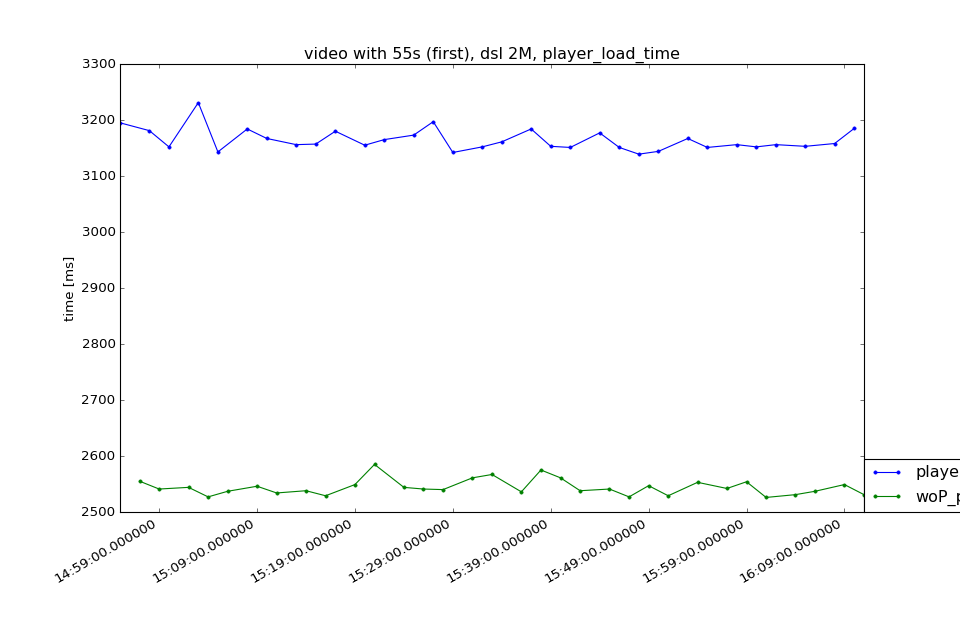

<IPython.core.display.Javascript object>


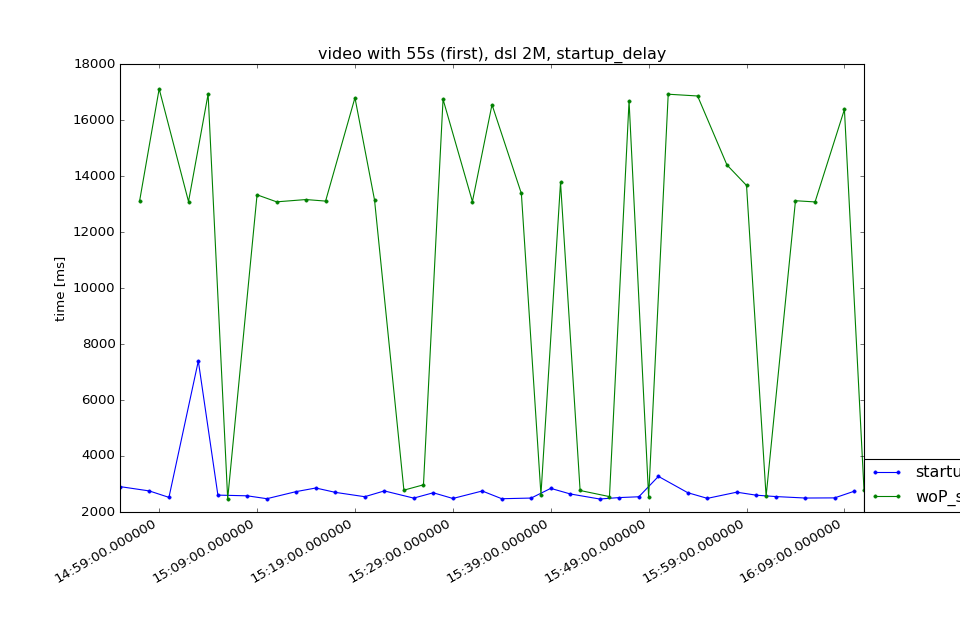

<IPython.core.display.Javascript object>


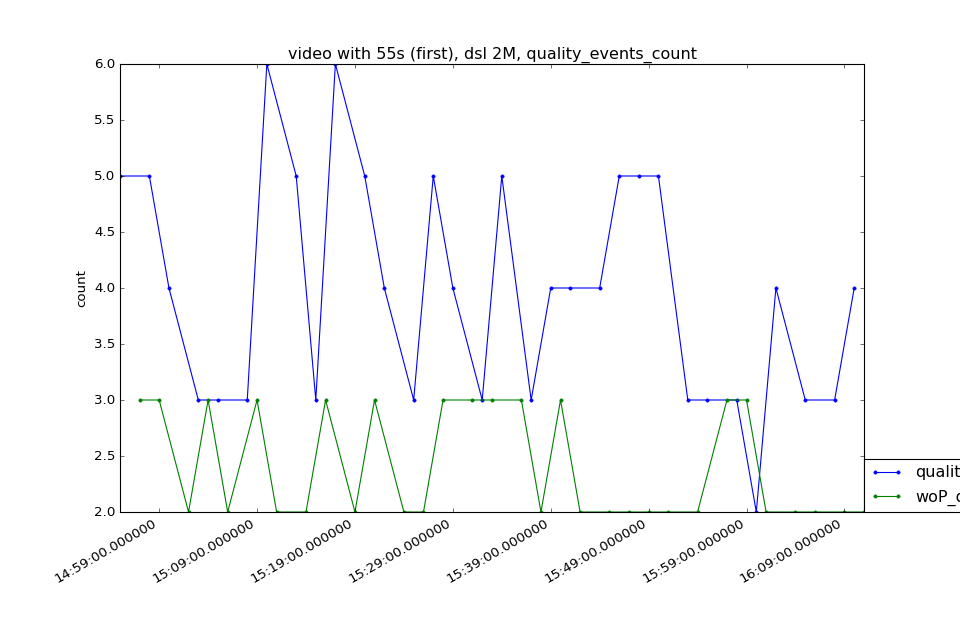

<IPython.core.display.Javascript object>


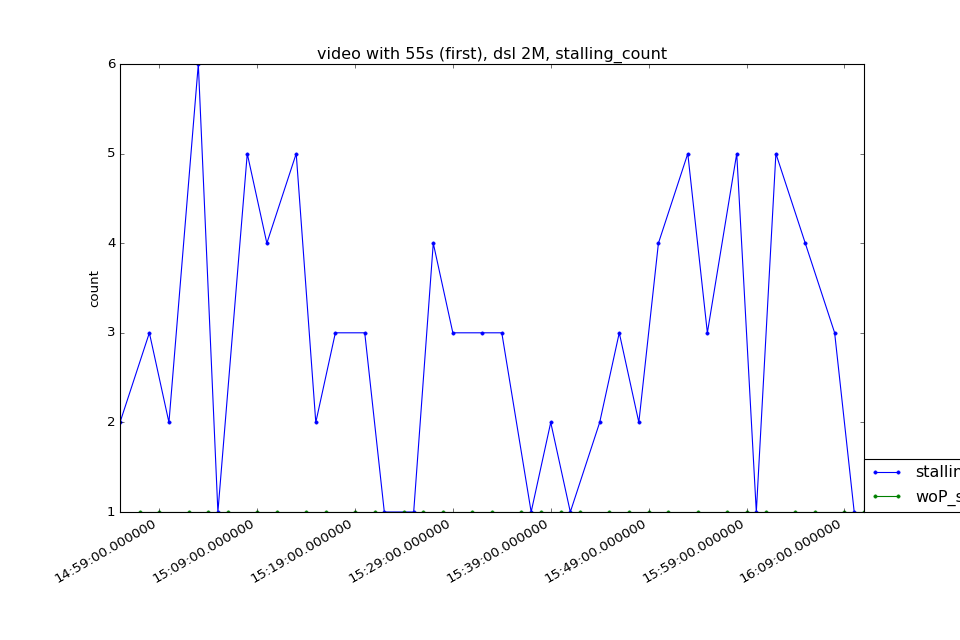

<IPython.core.display.Javascript object>


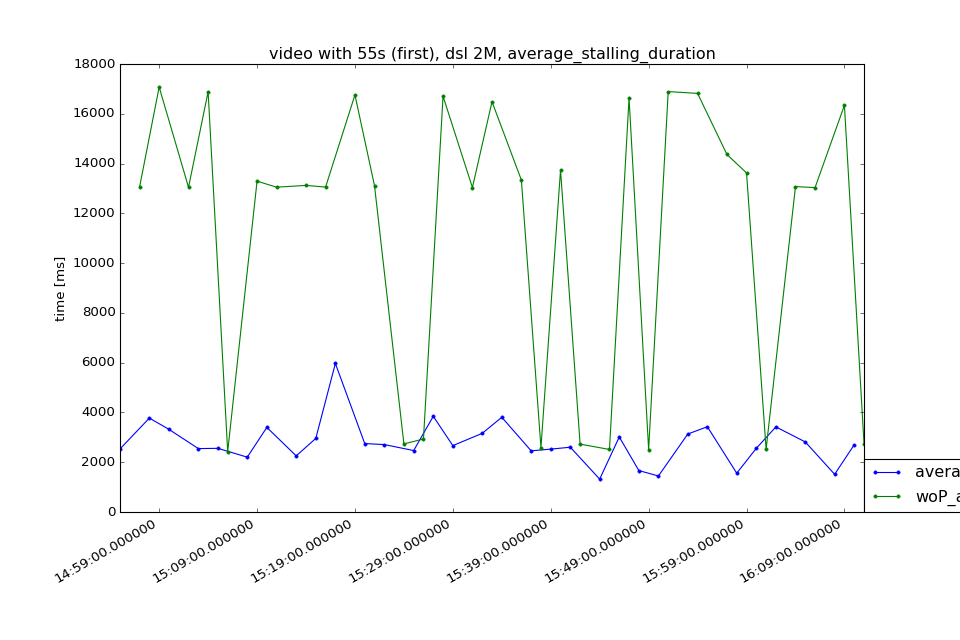

<IPython.core.display.Javascript object>


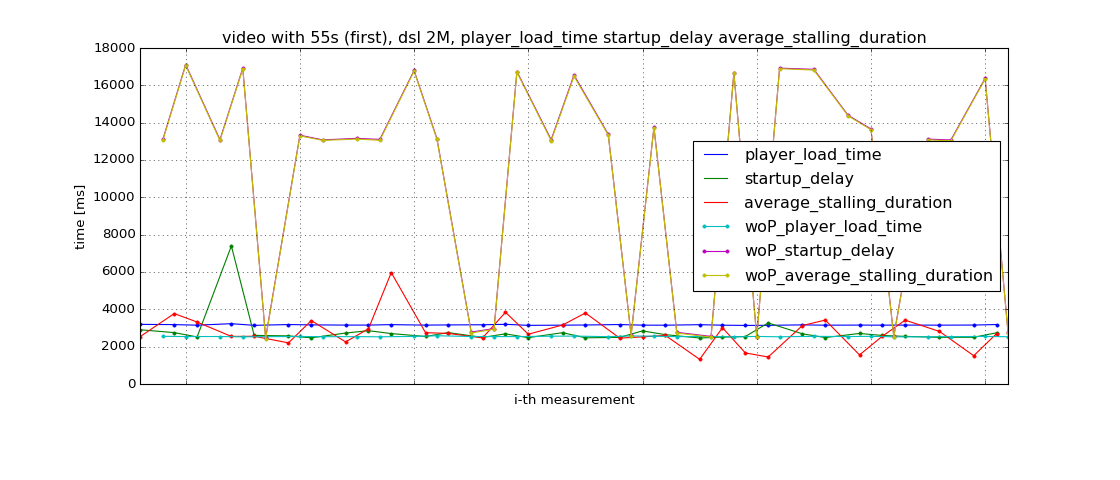

{'hd720': 47, 'hd1080': 38, 'large': 42}


<IPython.core.display.Javascript object>


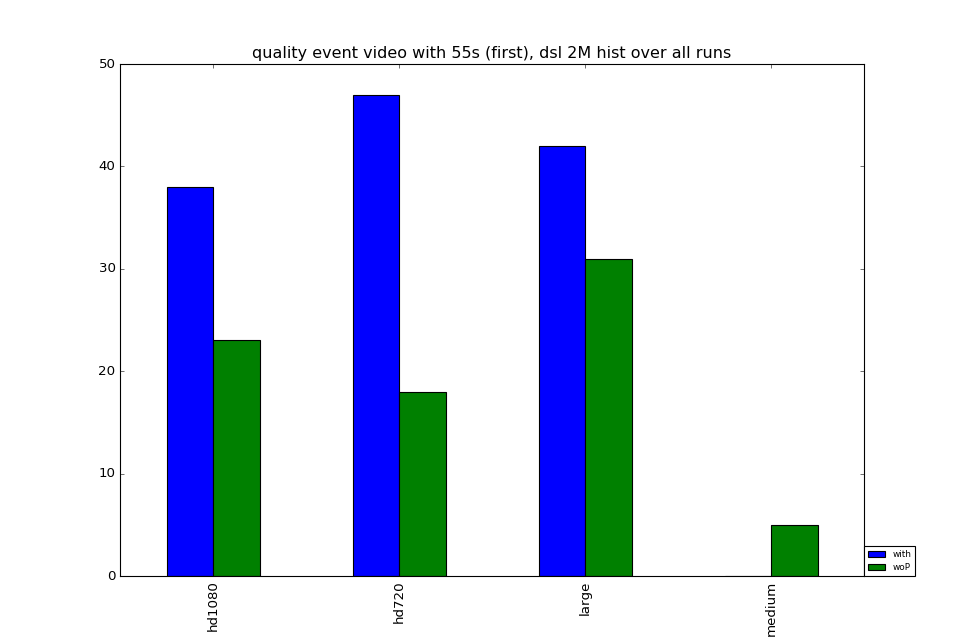

calulate mean
with proxy:
average_stalling_duration    2783.91875
player_load_time             3164.62500
quality_events_count            3.96875
stalling_count                  2.90625
startup_delay                2789.62500
dtype: float64
without proxy:
average_stalling_duration    11257.28125
player_load_time              2544.21875
quality_events_count             2.40625
stalling_count                   1.00000
startup_delay                11296.78125
dtype: float64
mean diff (without - with)
average_stalling_duration    8473.36250
player_load_time             -620.40625
quality_events_count           -1.56250
stalling_count                 -1.90625
startup_delay                8507.15625
dtype: float64
var diff(without -with)
average_stalling_duration    31437723.72
player_load_time                 -190.19
quality_events_count               -0.81
stalling_count                     -2.15
startup_delay                31492300.90
dtype: float64


In [2]:
basedir = "first_2k"
title = "video with 55s (first), dsl 2M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy, title)
print_differences_and_mean(data, data_without_proxy)

## Results: first
* approximately simuliar quality/stalling behaivior
* differences in mean values somehow "constant"


read with and without proxy files of second_2k


<IPython.core.display.Javascript object>


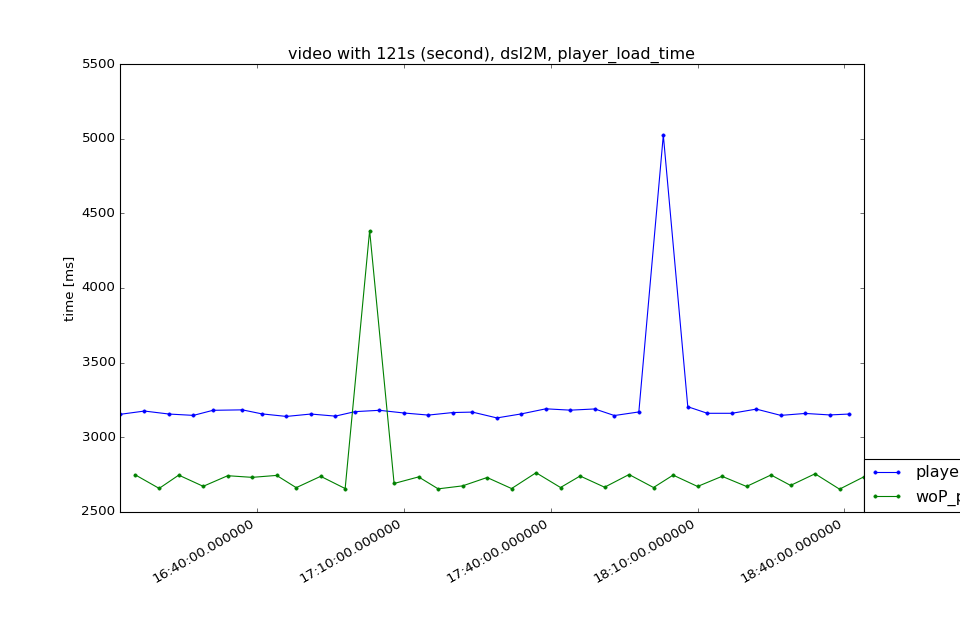

<IPython.core.display.Javascript object>


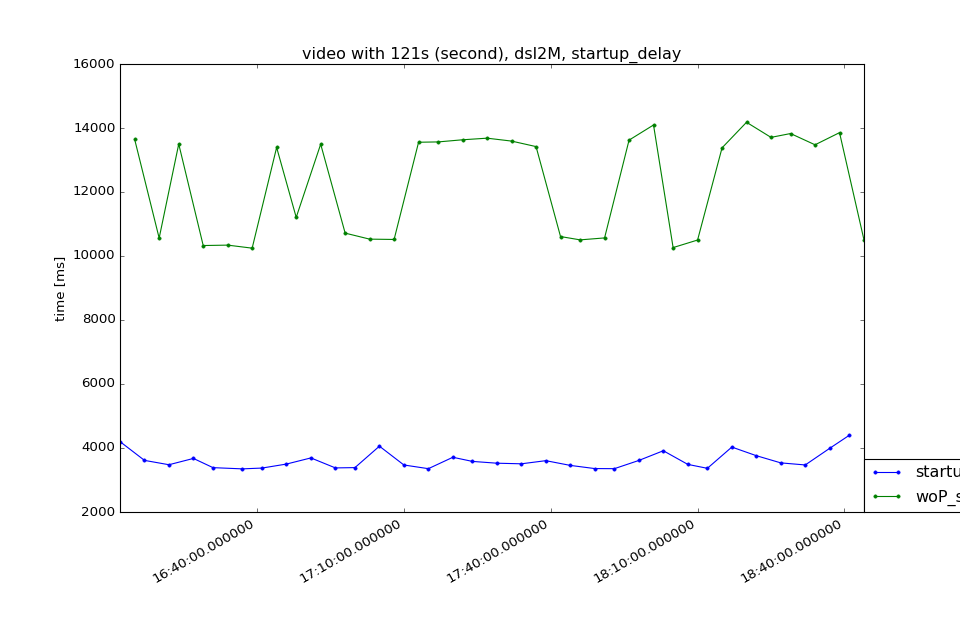

<IPython.core.display.Javascript object>


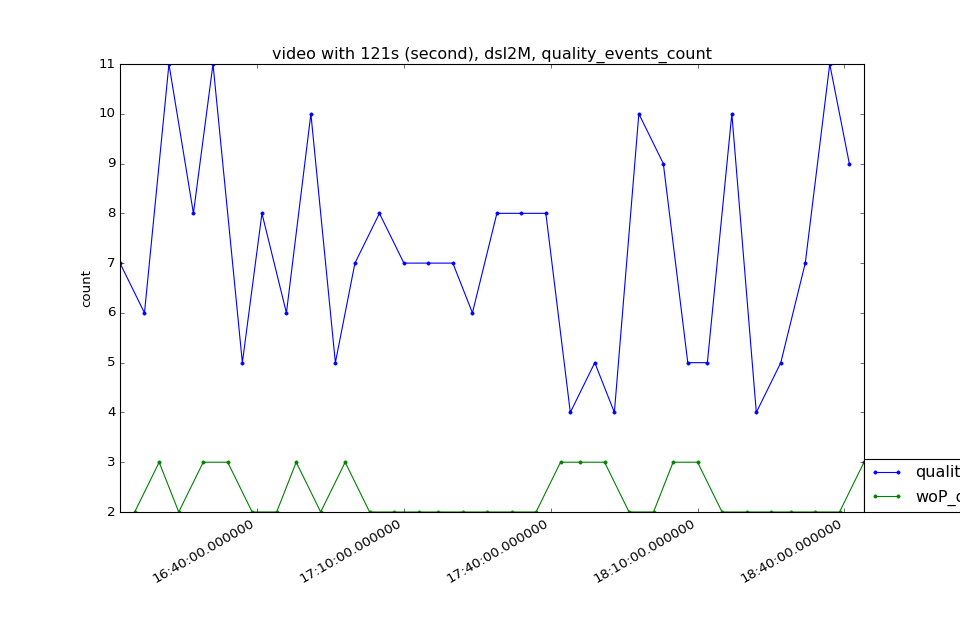

<IPython.core.display.Javascript object>


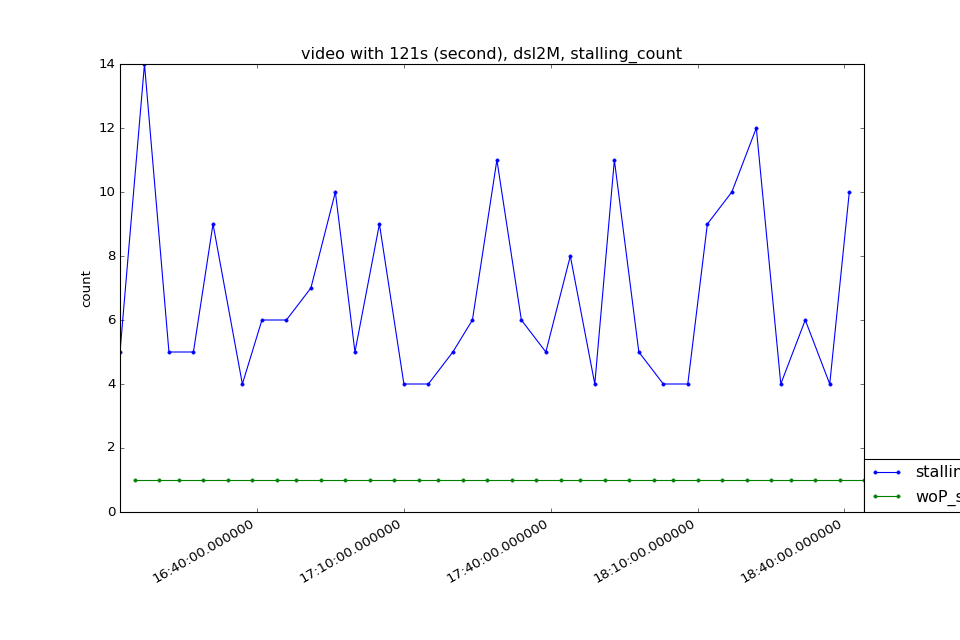

<IPython.core.display.Javascript object>


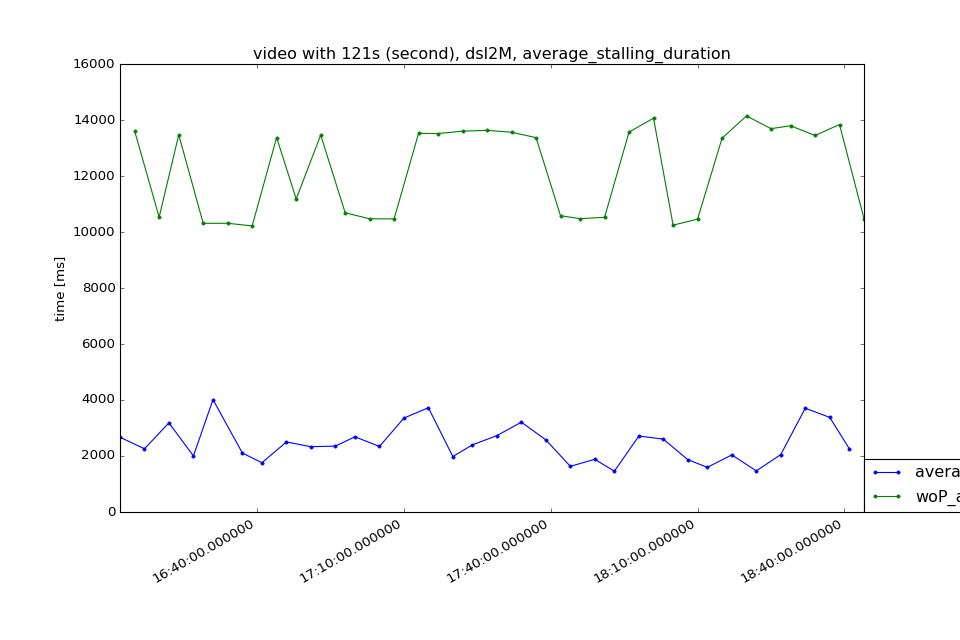

<IPython.core.display.Javascript object>


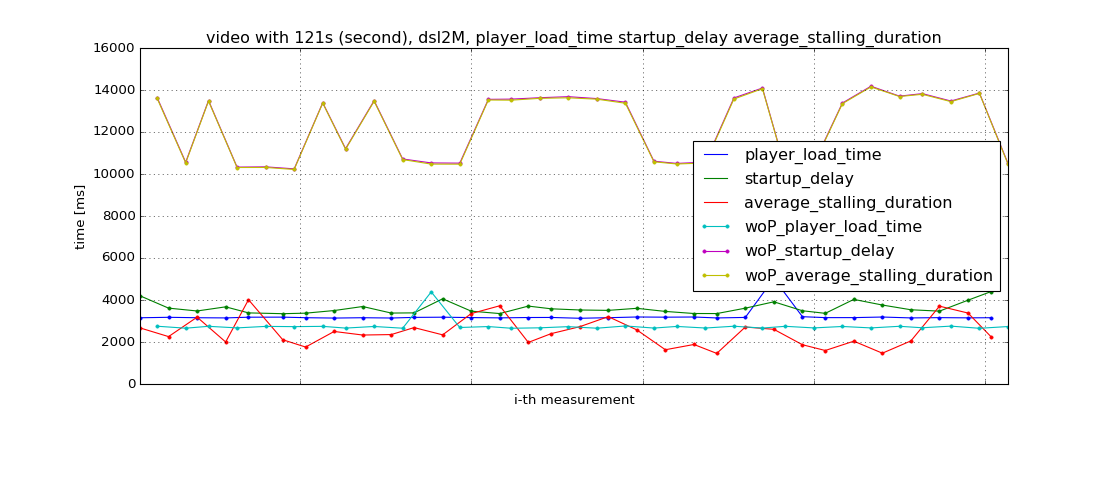

{'hd720': 97, 'hd1080': 96, 'large': 38}


<IPython.core.display.Javascript object>


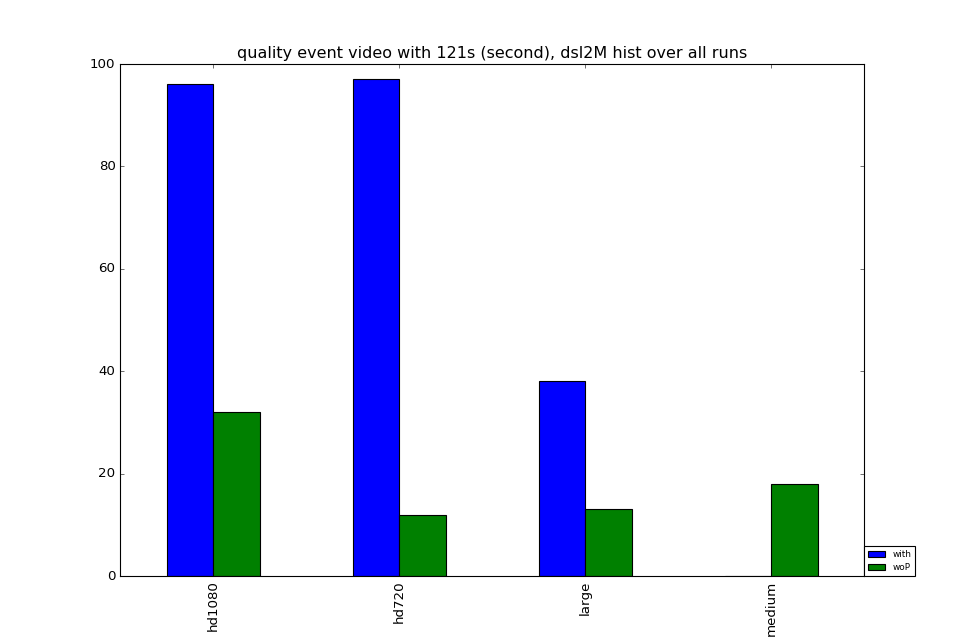

calulate mean
with proxy:
average_stalling_duration    2463.549007
player_load_time             3222.250000
quality_events_count            7.218750
stalling_count                  6.781250
startup_delay                3611.187500
dtype: float64
without proxy:
average_stalling_duration    12248.50000
player_load_time              2758.87500
quality_events_count             2.34375
stalling_count                   1.00000
startup_delay                12280.87500
dtype: float64
mean diff (without - with)
average_stalling_duration    9784.950993
player_load_time             -463.375000
quality_events_count           -4.875000
stalling_count                 -5.781250
startup_delay                8669.687500
dtype: float64
var diff(without -with)
average_stalling_duration    2060986.92
player_load_time              -18753.76
quality_events_count              -4.33
stalling_count                    -8.05
startup_delay                2446536.34
dtype: float64


In [3]:
basedir = "second_2k"
title = "video with 121s (second), dsl2M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy, title)
print_differences_and_mean(data, data_without_proxy)

## Results: second
* approximately simuliar quality/stalling behaivior
* differences in mean values somehow "constant", approx same compared to first


read with and without proxy files of third_2k


<IPython.core.display.Javascript object>


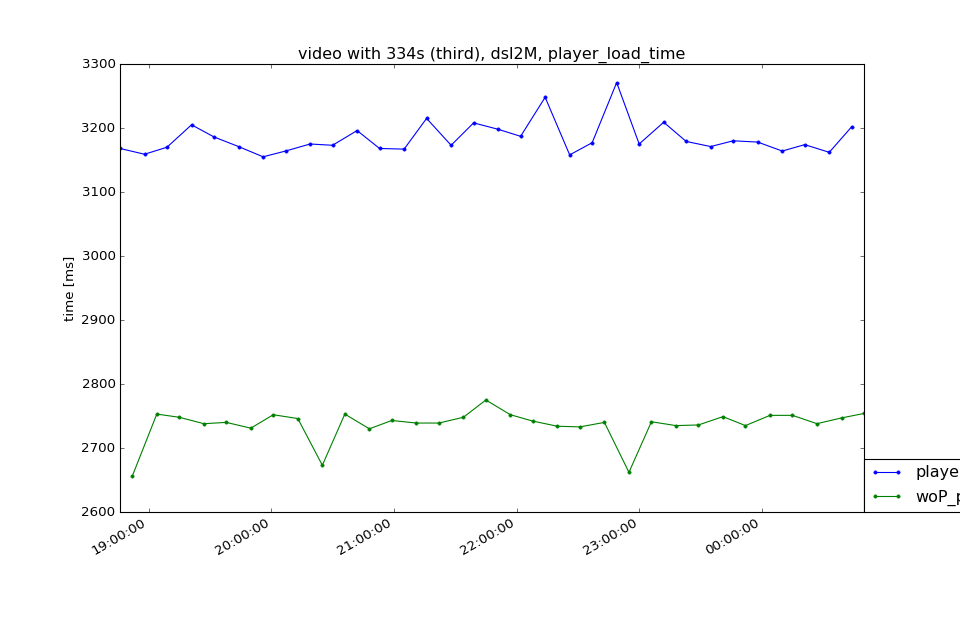

<IPython.core.display.Javascript object>


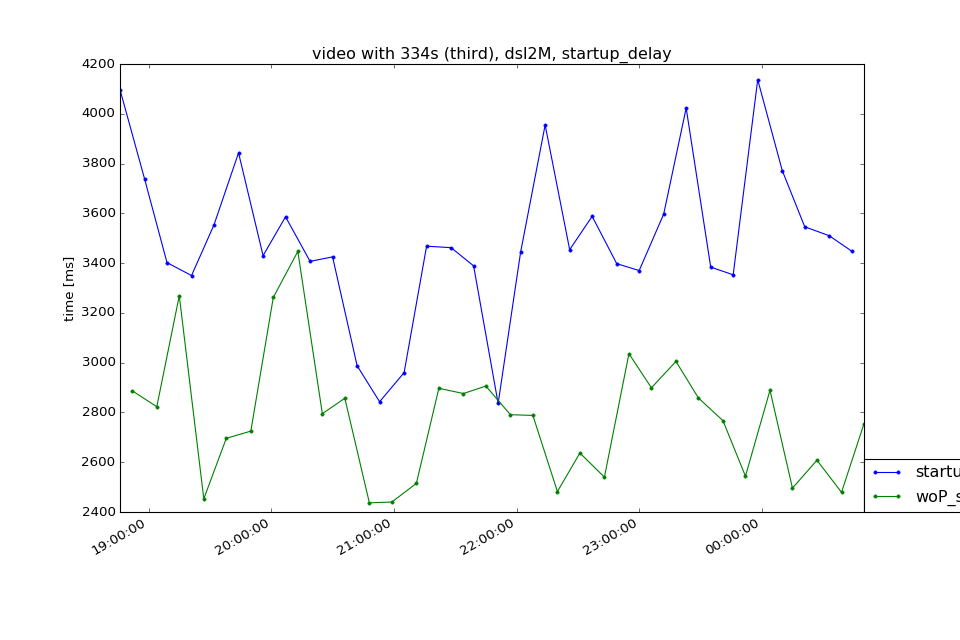

<IPython.core.display.Javascript object>


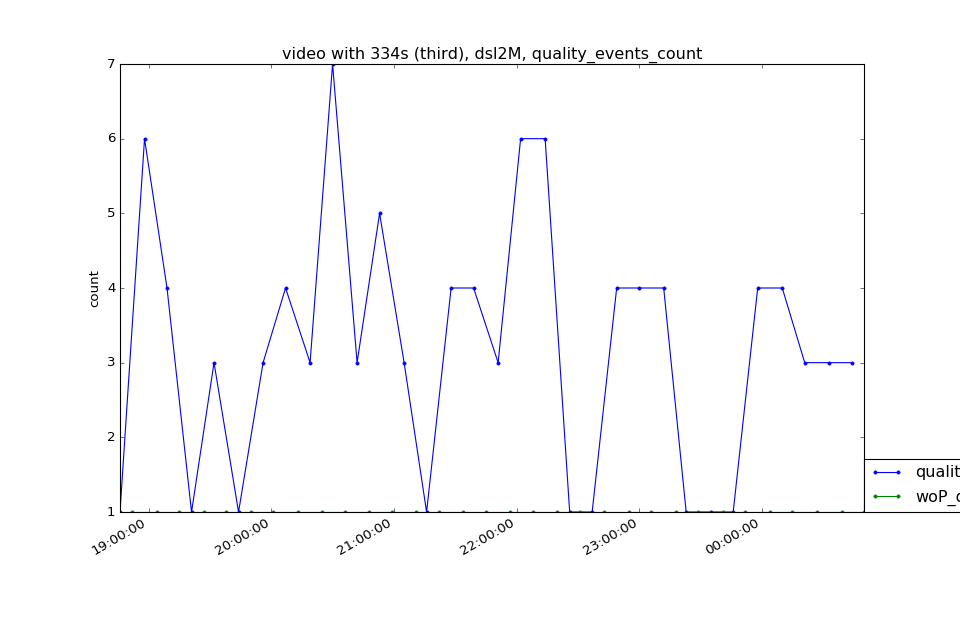

<IPython.core.display.Javascript object>


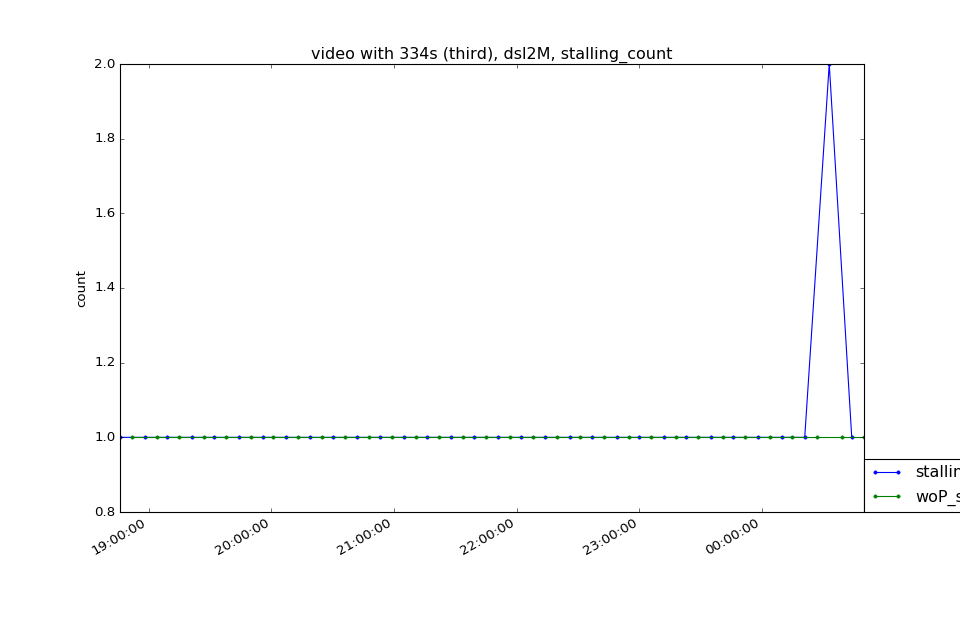

<IPython.core.display.Javascript object>


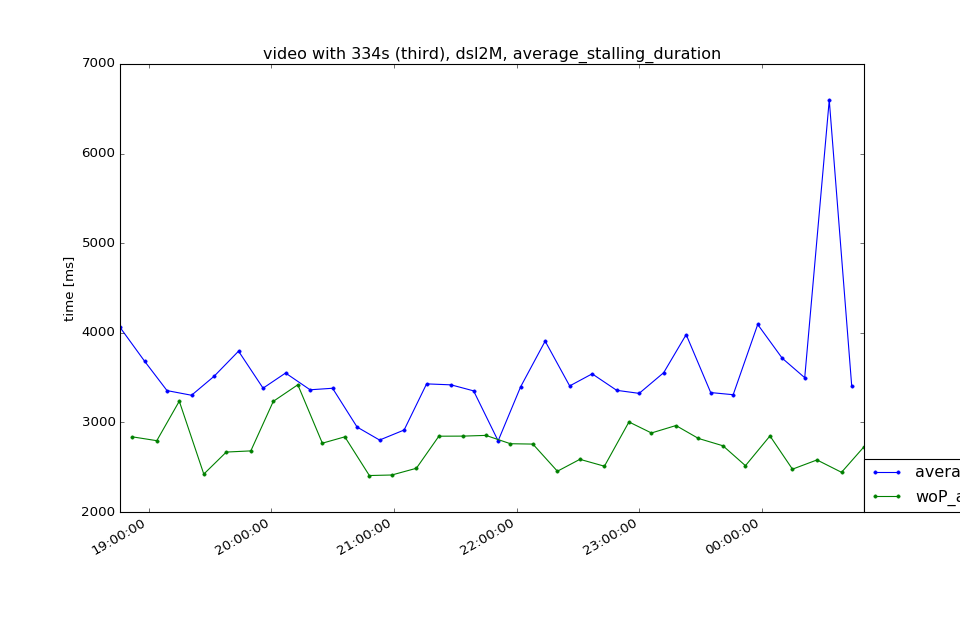

<IPython.core.display.Javascript object>


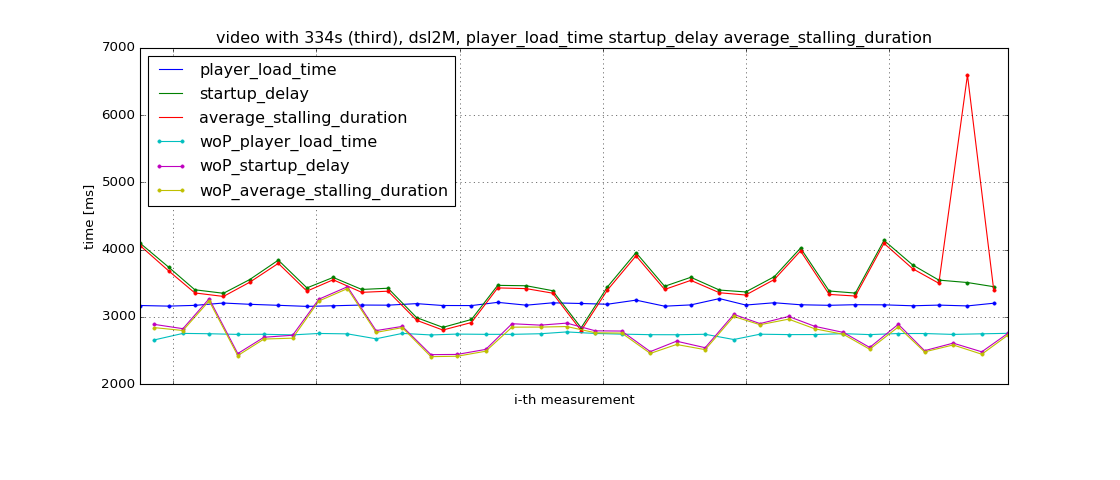

{'hd720': 61, 'medium': 20, 'large': 21}


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


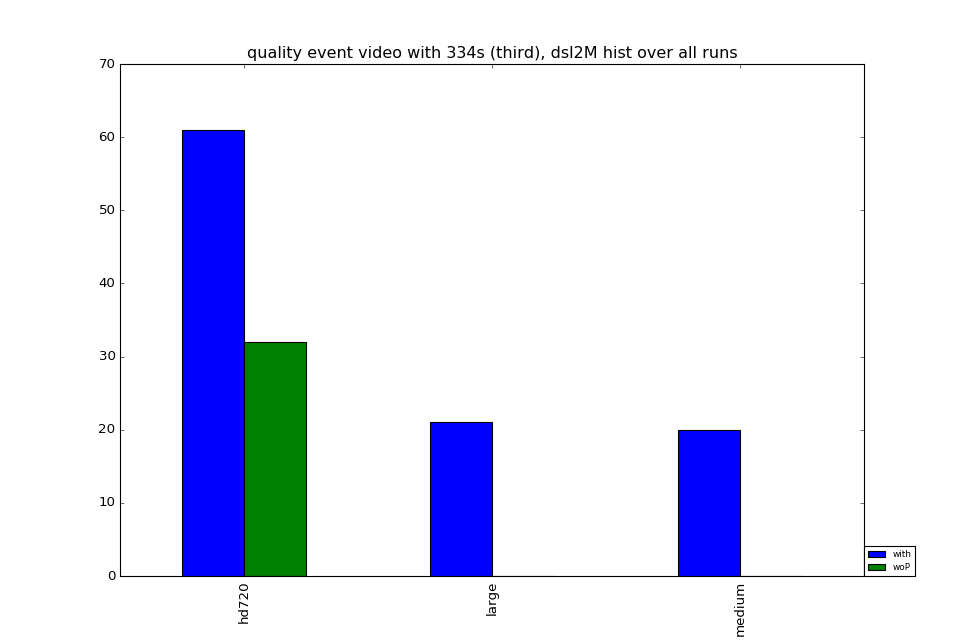

calulate mean
with proxy:
average_stalling_duration    3546.00000
player_load_time             3183.93750
quality_events_count            3.18750
stalling_count                  1.03125
startup_delay                3492.43750
dtype: float64
without proxy:
average_stalling_duration    2745.18750
player_load_time             2736.37500
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                2776.84375
dtype: float64
mean diff (without - with)
average_stalling_duration   -800.81250
player_load_time            -447.56250
quality_events_count          -2.18750
stalling_count                -0.03125
startup_delay               -715.59375
dtype: float64
var diff(without -with)
average_stalling_duration   -346138.81
player_load_time                 -6.08
quality_events_count             -2.93
stalling_count                   -0.03
startup_delay                -35955.80
dtype: float64


In [4]:
basedir = "third_2k"
title = "video with 334s (third), dsl2M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)

## Results: third
* huge difference in all parts
* maybe based on changed network competitions 


read with and without proxy files of first_6k


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


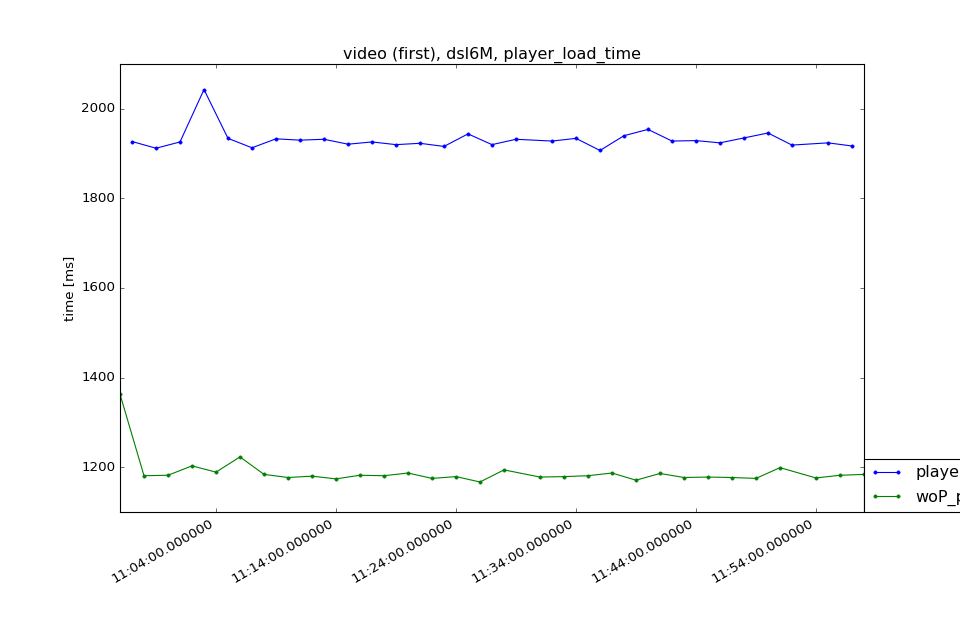

<IPython.core.display.Javascript object>


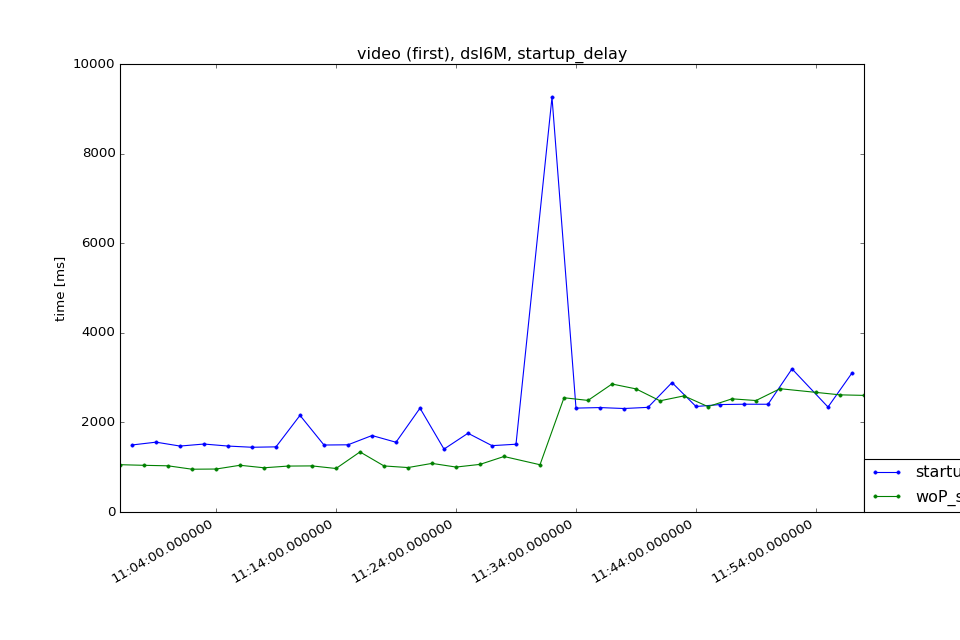

<IPython.core.display.Javascript object>


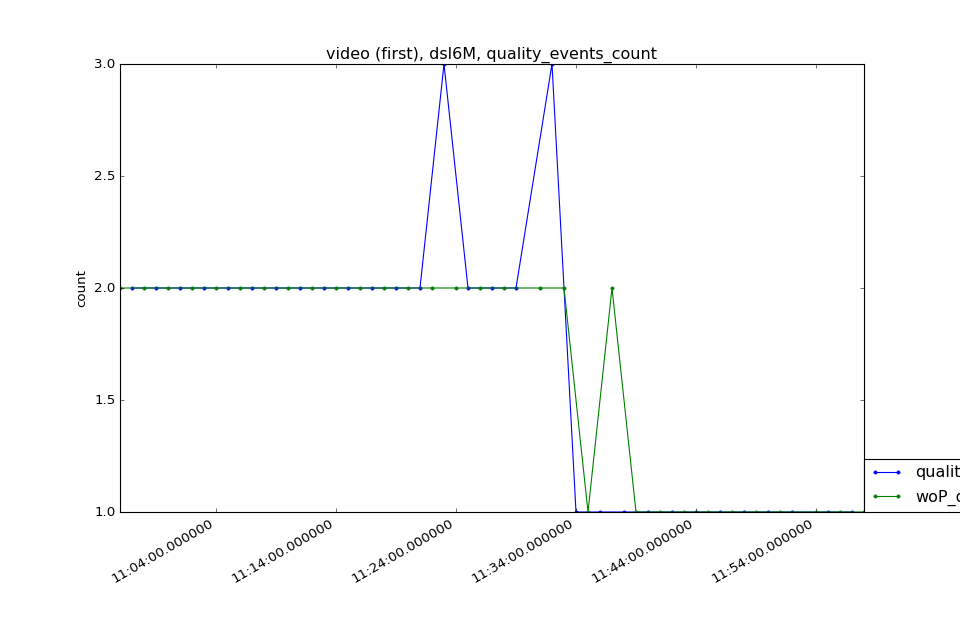

<IPython.core.display.Javascript object>


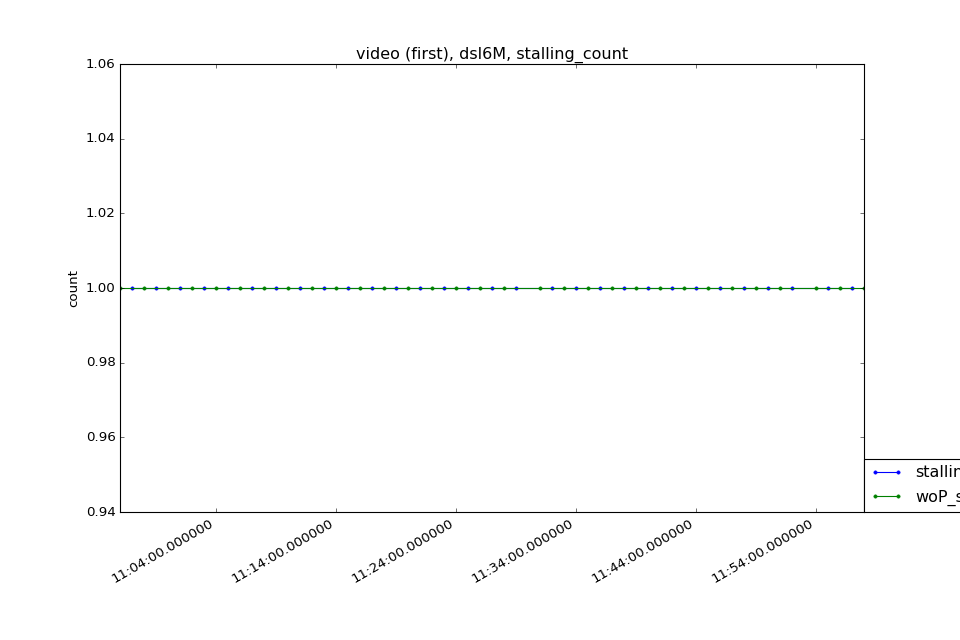

<IPython.core.display.Javascript object>


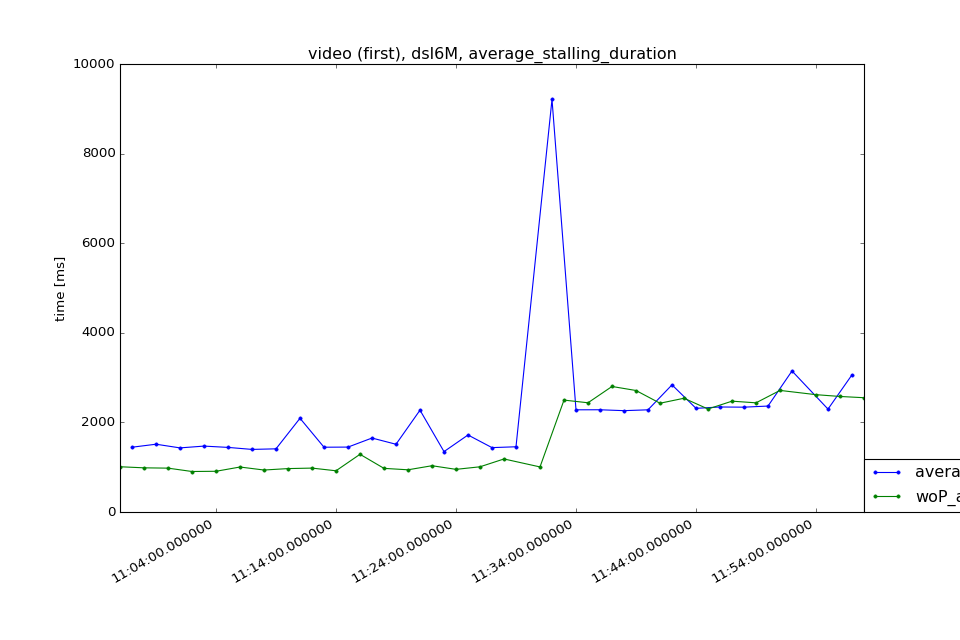

<IPython.core.display.Javascript object>


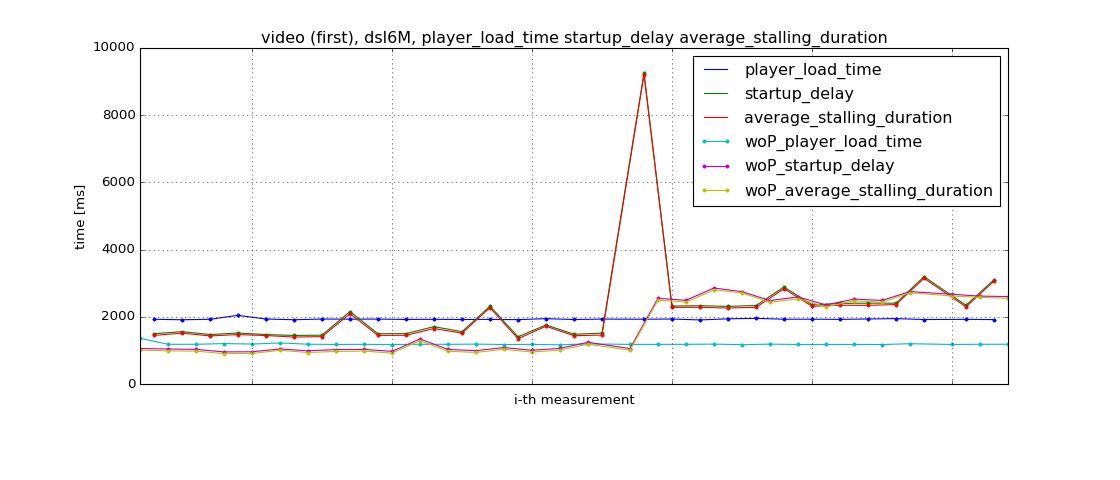

{'hd1080': 30, 'hd720': 2, 'large': 18}


<IPython.core.display.Javascript object>


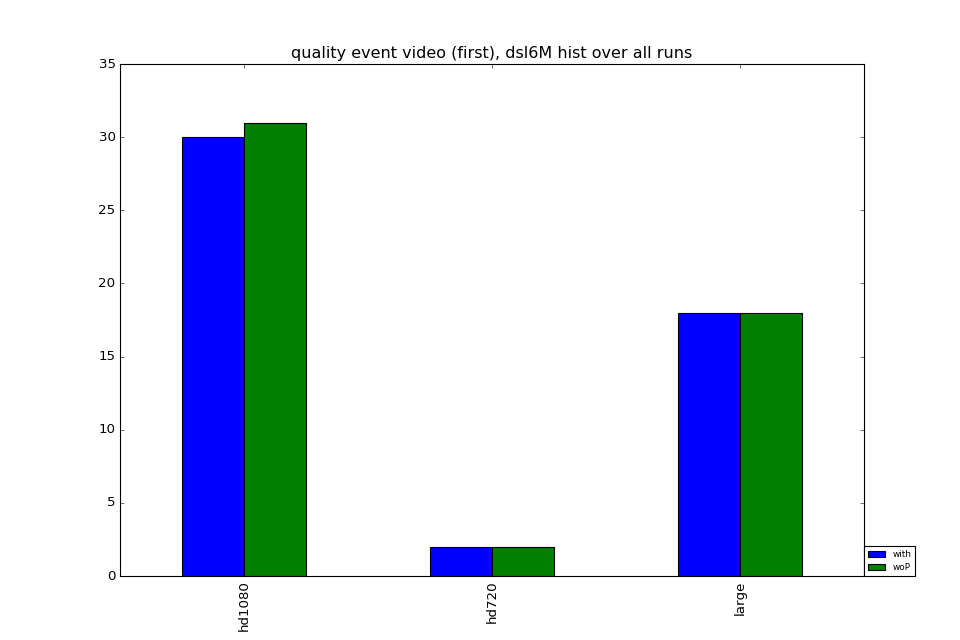

calulate mean
with proxy:
average_stalling_duration    2183.900000
player_load_time             1931.233333
quality_events_count            1.666667
stalling_count                  1.000000
startup_delay                2231.766667
dtype: float64
without proxy:
average_stalling_duration    1647.612903
player_load_time             1188.741935
quality_events_count            1.645161
stalling_count                  1.000000
startup_delay                1697.741935
dtype: float64
mean diff (without - with)
average_stalling_duration   -536.287097
player_load_time            -742.491398
quality_events_count          -0.021505
stalling_count                 0.000000
startup_delay               -534.024731
dtype: float64
var diff(without -with)
average_stalling_duration   -1431027.72
player_load_time                 604.96
quality_events_count              -0.13
stalling_count                     0.00
startup_delay               -1433347.95
dtype: float64


In [5]:
basedir = "first_6k"
title = "video (first), dsl6M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)

read with and without proxy files of second_6k


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


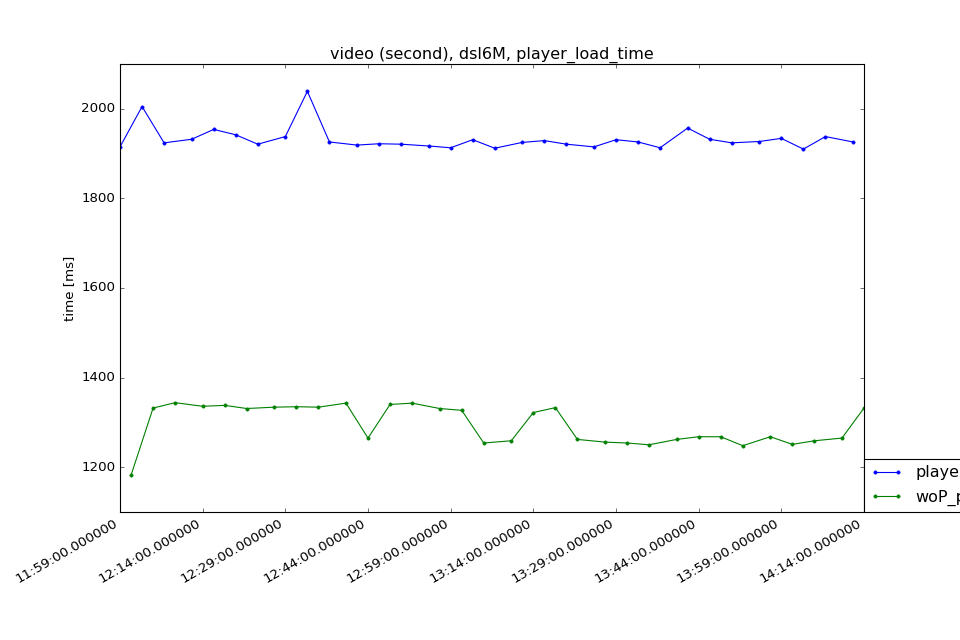

<IPython.core.display.Javascript object>


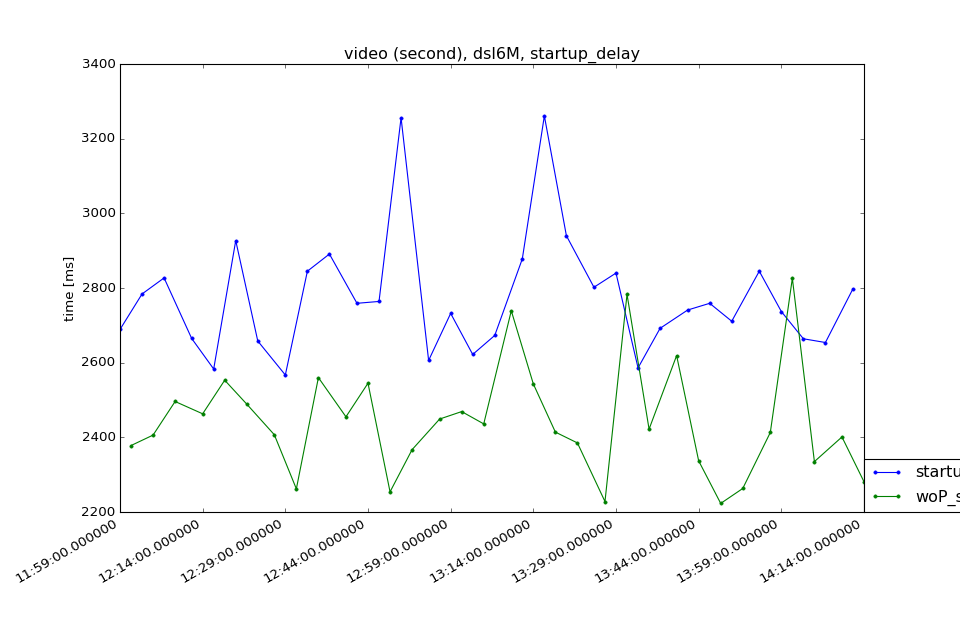

<IPython.core.display.Javascript object>


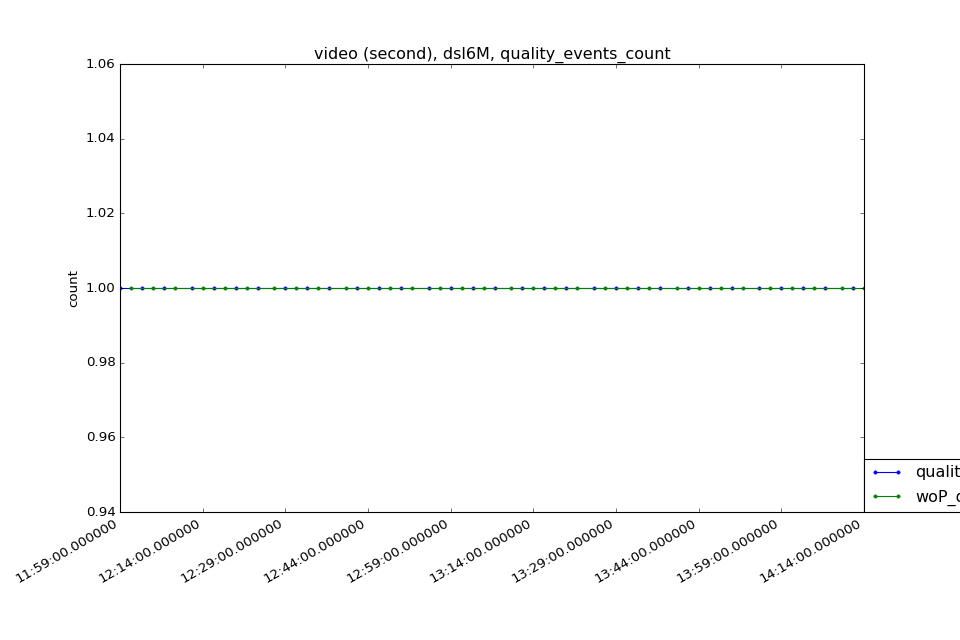

<IPython.core.display.Javascript object>


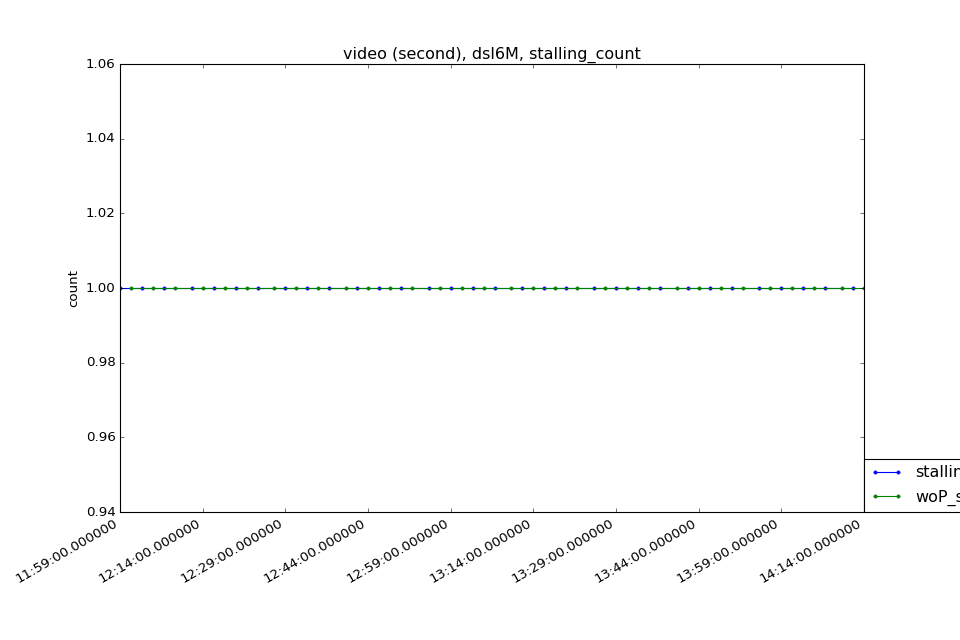

<IPython.core.display.Javascript object>


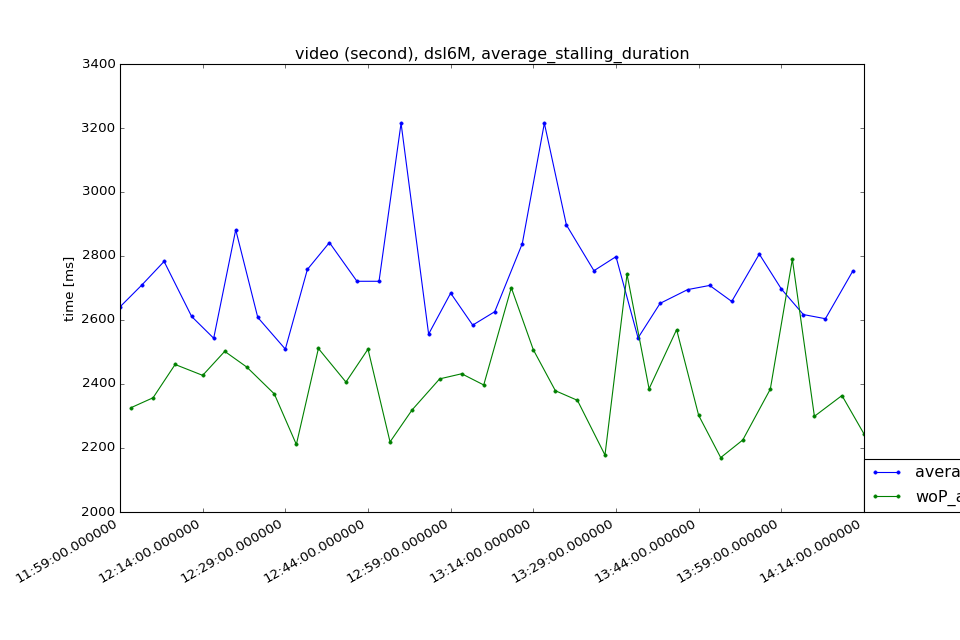

<IPython.core.display.Javascript object>


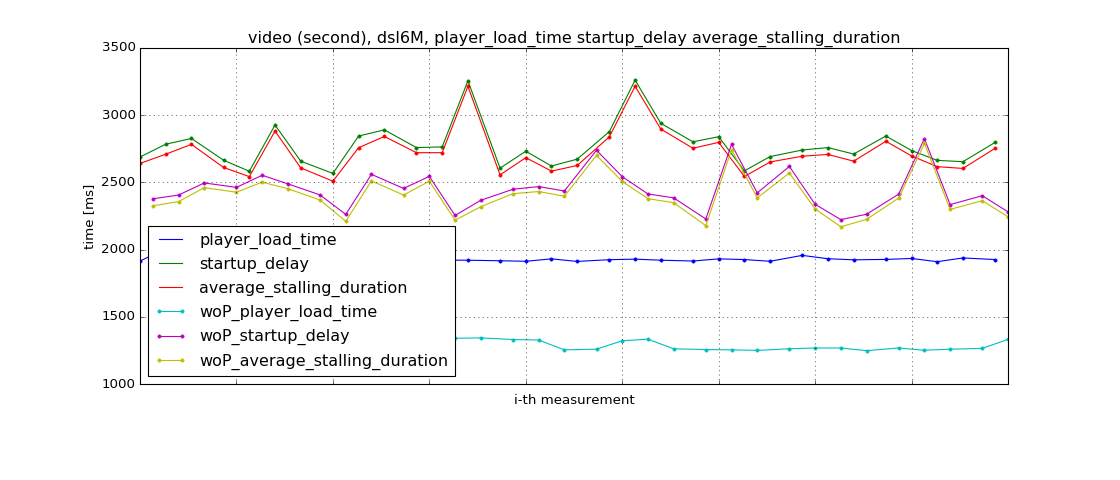

{'hd1080': 32}


<IPython.core.display.Javascript object>


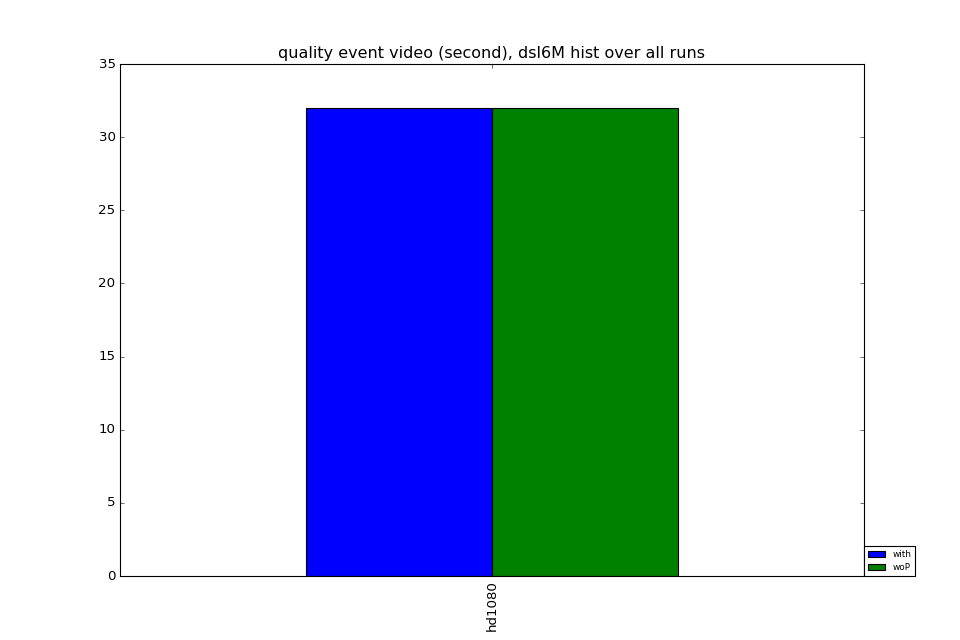

calulate mean
with proxy:
average_stalling_duration    2726.00000
player_load_time             1932.46875
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                2773.62500
dtype: float64
without proxy:
average_stalling_duration    2403.28125
player_load_time             1294.56250
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                2443.78125
dtype: float64
mean diff (without - with)
average_stalling_duration   -322.71875
player_load_time            -637.90625
quality_events_count           0.00000
stalling_count                 0.00000
startup_delay               -329.84375
dtype: float64
var diff(without -with)
average_stalling_duration   -3710.57
player_load_time             1189.93
quality_events_count            0.00
stalling_count                  0.00
startup_delay               -3757.55
dtype: float64


In [6]:
basedir = "second_6k"
title = "video (second), dsl6M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)

read with and without proxy files of third_6k


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


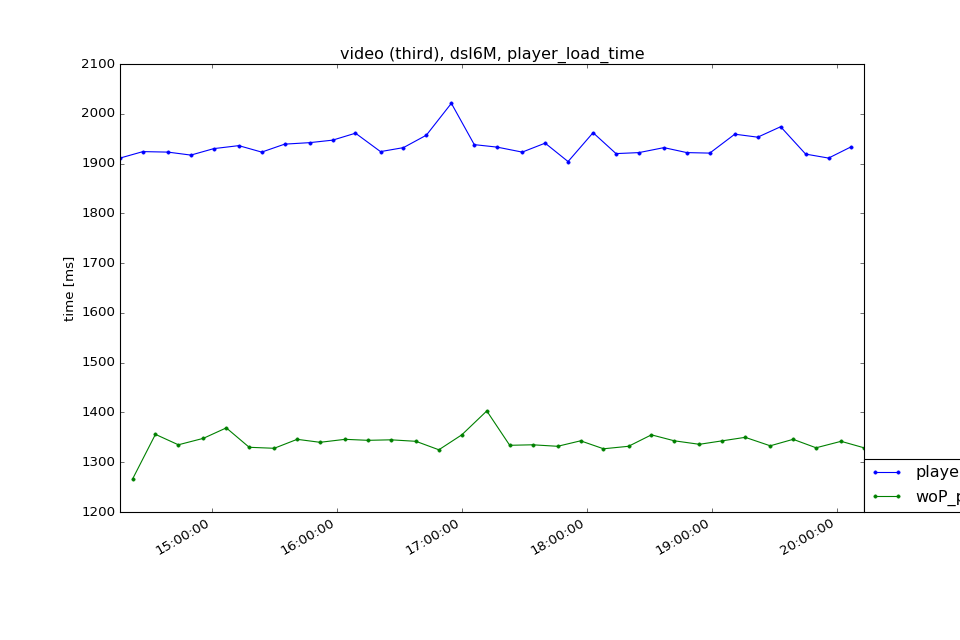

<IPython.core.display.Javascript object>


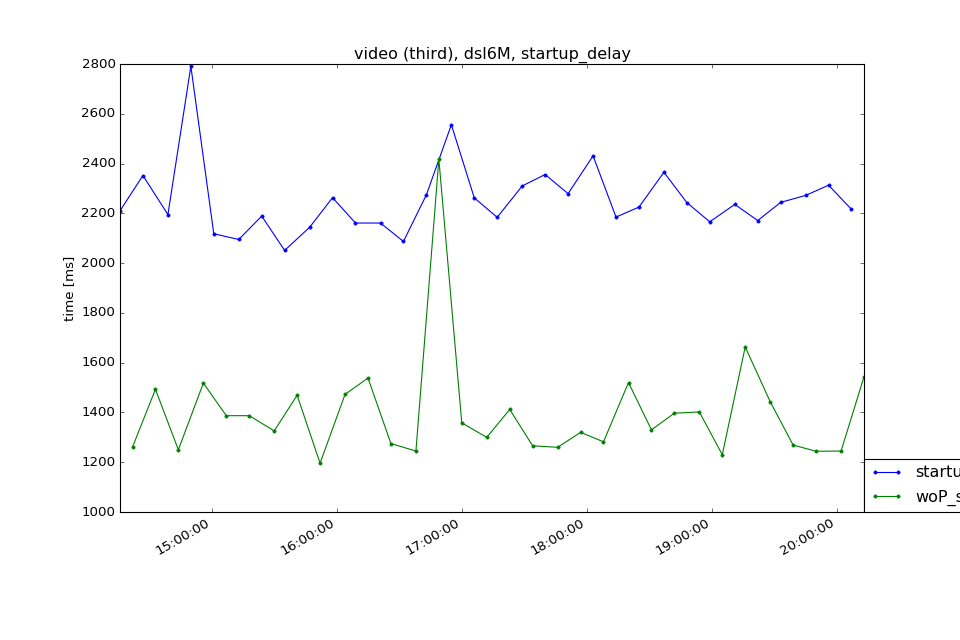

<IPython.core.display.Javascript object>


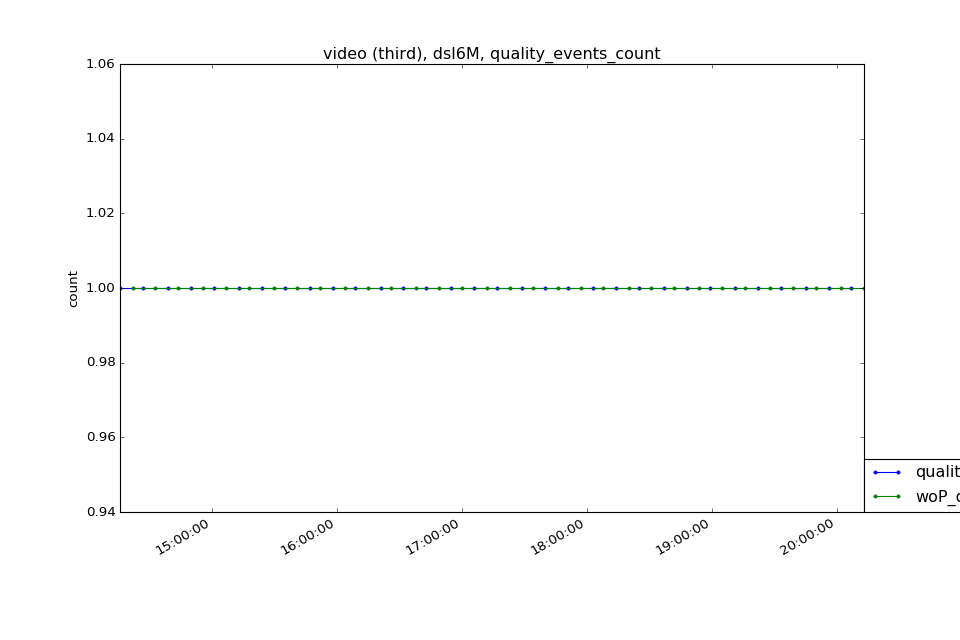

<IPython.core.display.Javascript object>


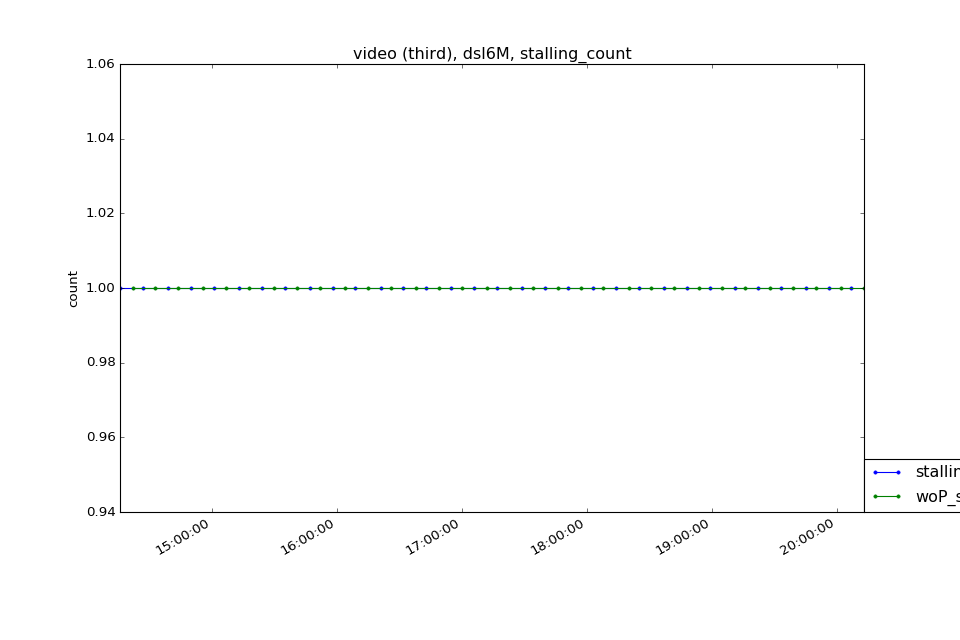

<IPython.core.display.Javascript object>


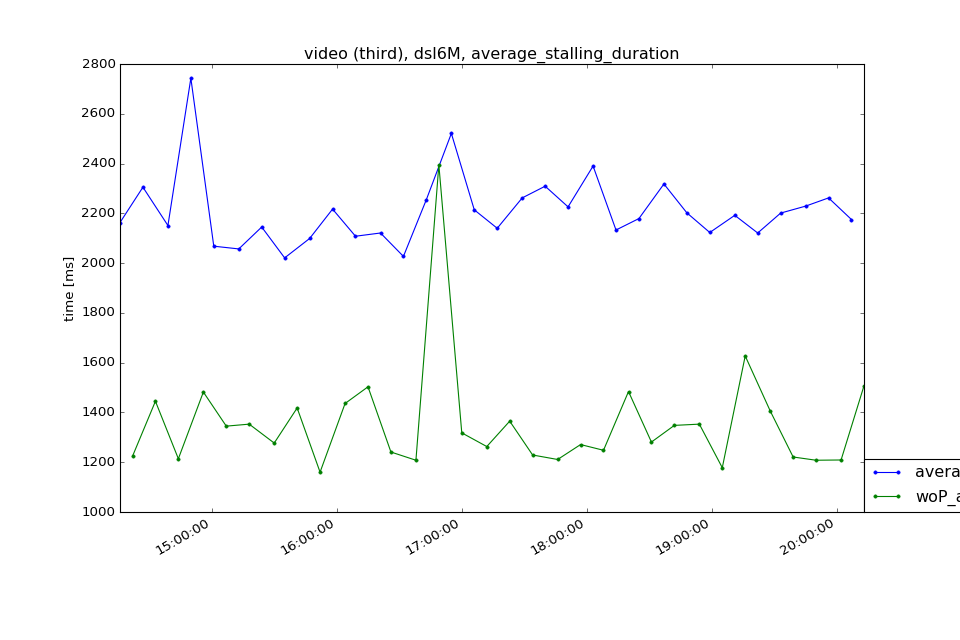

<IPython.core.display.Javascript object>


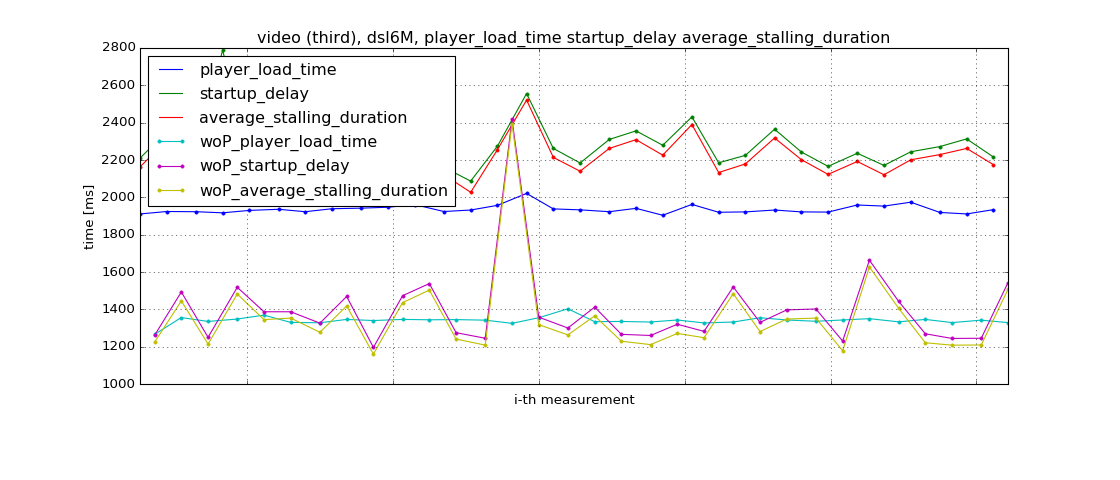

{'hd720': 32}


<IPython.core.display.Javascript object>


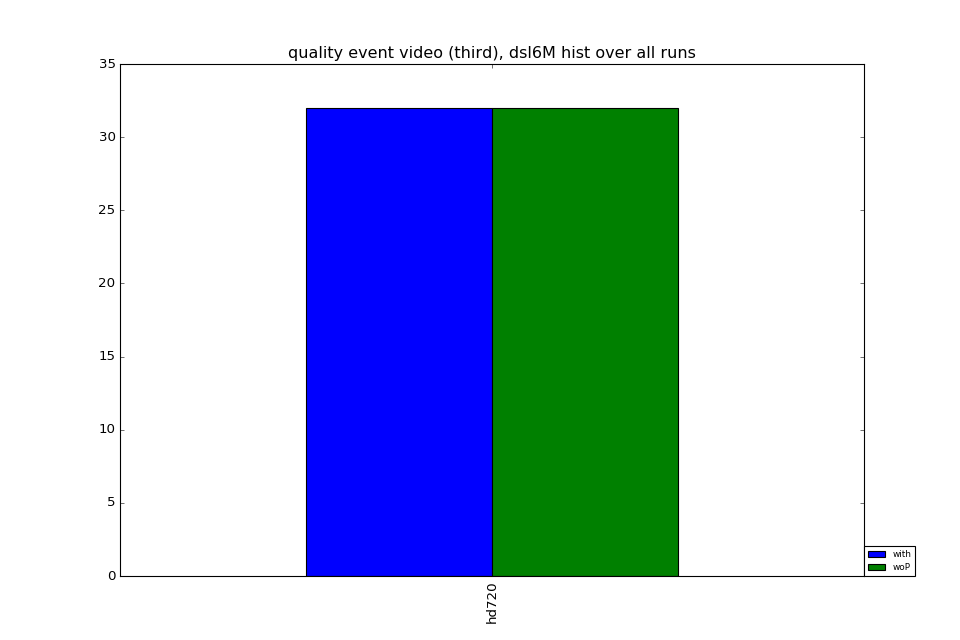

calulate mean
with proxy:
average_stalling_duration    2208.65625
player_load_time             1936.09375
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                2253.28125
dtype: float64
without proxy:
average_stalling_duration    1357.12500
player_load_time             1340.21875
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                1397.50000
dtype: float64
mean diff (without - with)
average_stalling_duration   -851.53125
player_load_time            -595.87500
quality_events_count           0.00000
stalling_count                 0.00000
startup_delay               -855.78125
dtype: float64
var diff(without -with)
average_stalling_duration    29000.72
player_load_time              -116.10
quality_events_count             0.00
stalling_count                   0.00
startup_delay                27785.73
dtype: float64


In [7]:
basedir = "third_6k"
title = "video (third), dsl6M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)

read with and without proxy files of first_25k


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


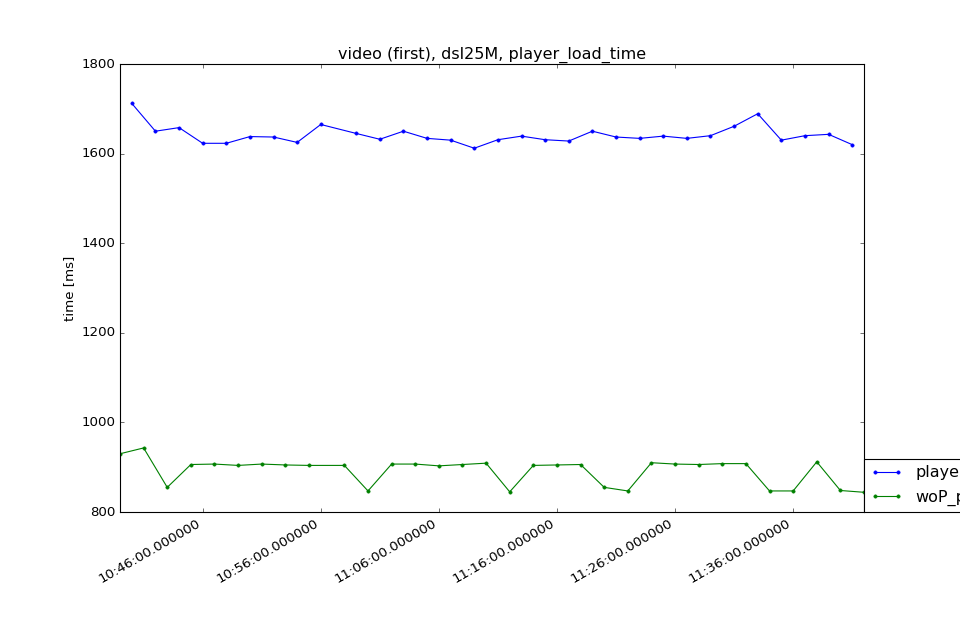

<IPython.core.display.Javascript object>


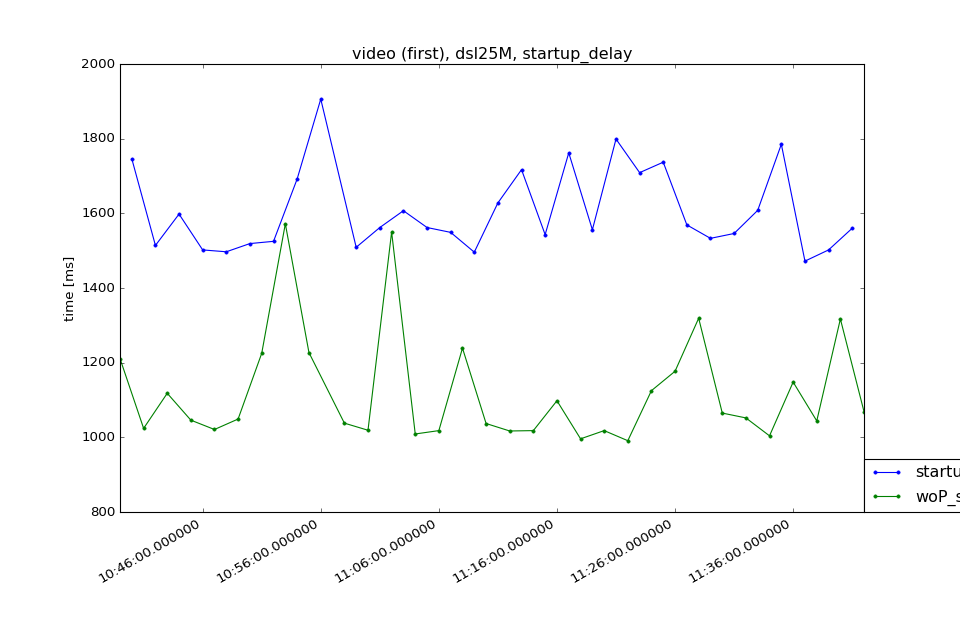

<IPython.core.display.Javascript object>


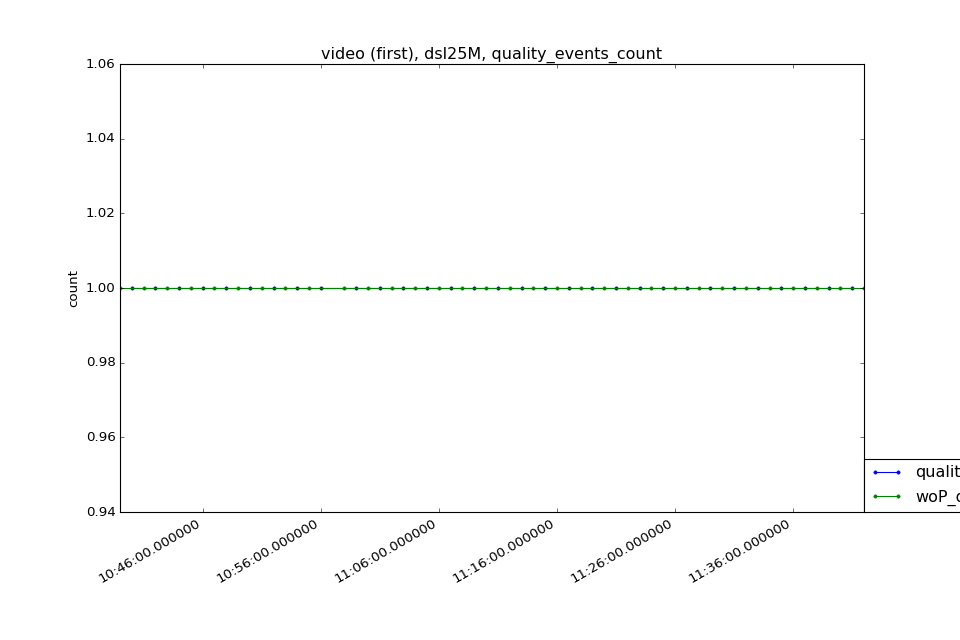

<IPython.core.display.Javascript object>


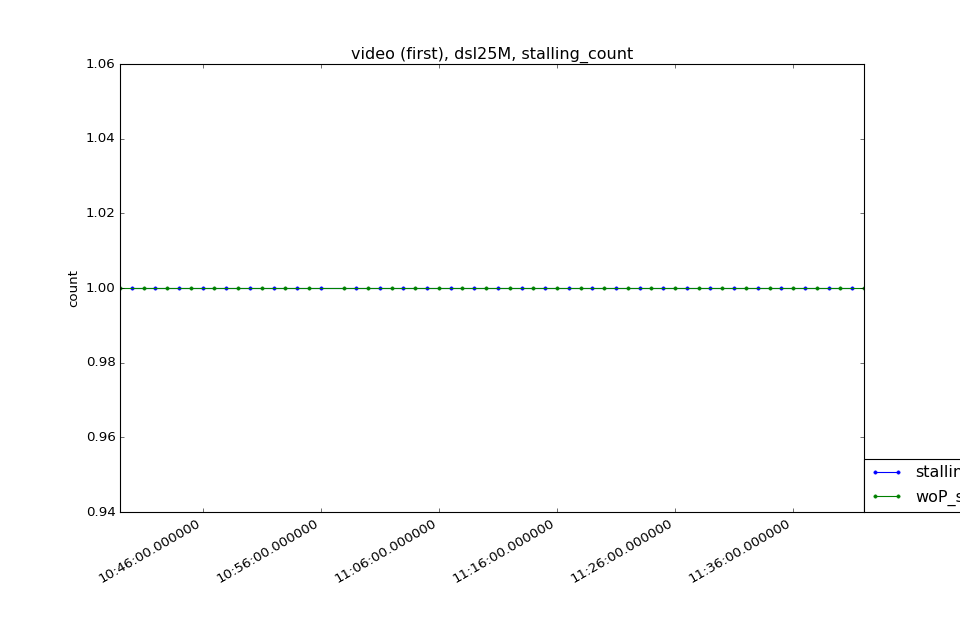

<IPython.core.display.Javascript object>


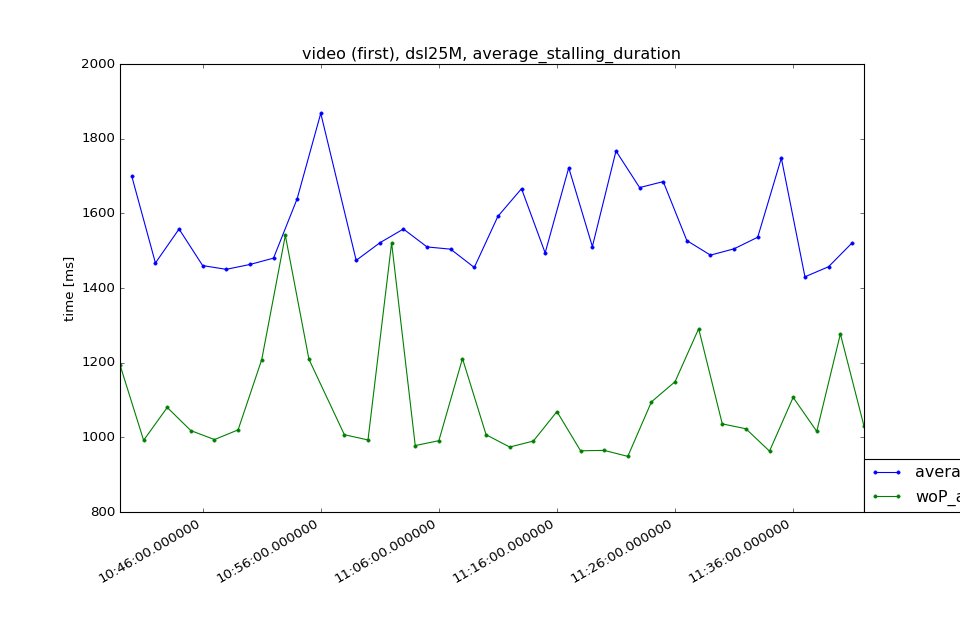

<IPython.core.display.Javascript object>


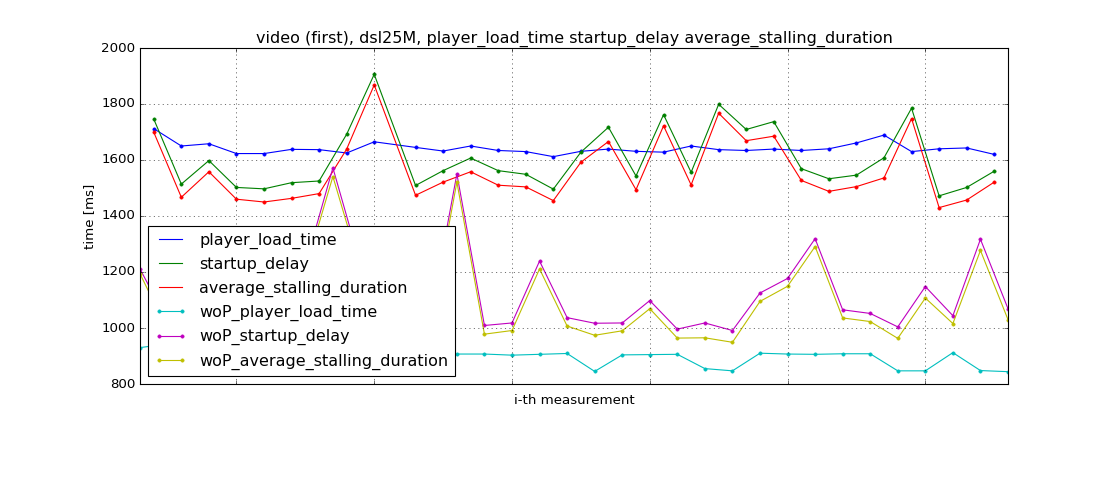

{'hd1080': 31}


<IPython.core.display.Javascript object>


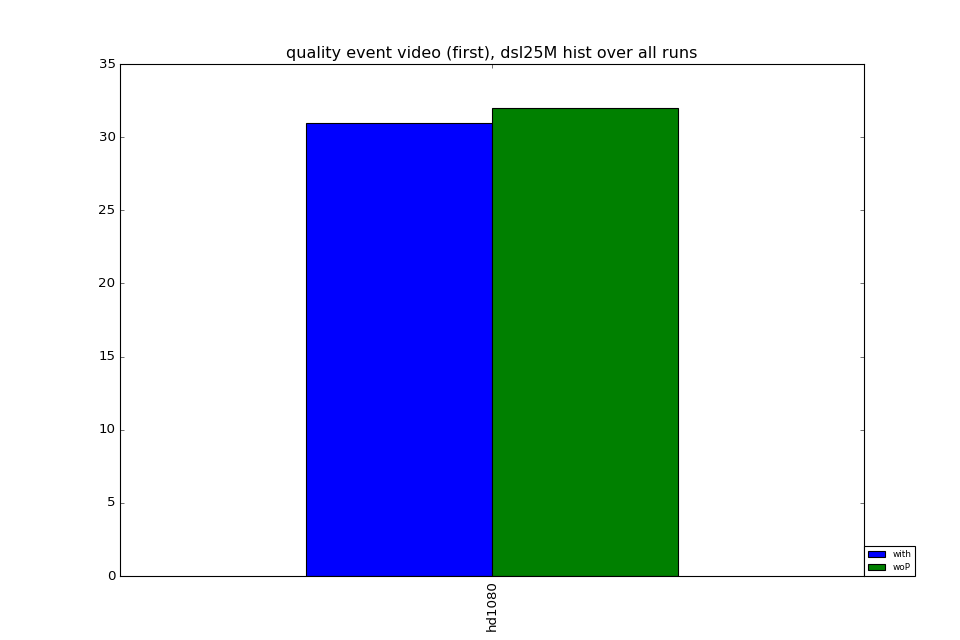

calulate mean
with proxy:
average_stalling_duration    1562.064516
player_load_time             1641.290323
quality_events_count            1.000000
stalling_count                  1.000000
startup_delay                1606.774194
dtype: float64
without proxy:
average_stalling_duration    1089.43750
player_load_time              891.96875
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                1120.65625
dtype: float64
mean diff (without - with)
average_stalling_duration   -472.627016
player_load_time            -749.321573
quality_events_count           0.000000
stalling_count                 0.000000
startup_delay               -486.117944
dtype: float64
var diff(without -with)
average_stalling_duration    9975.44
player_load_time              434.08
quality_events_count            0.00
stalling_count                  0.00
startup_delay                9703.24
dtype: float64


In [8]:
basedir = "first_25k"
title = "video (first), dsl25M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)

read with and without proxy files of second_25k


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


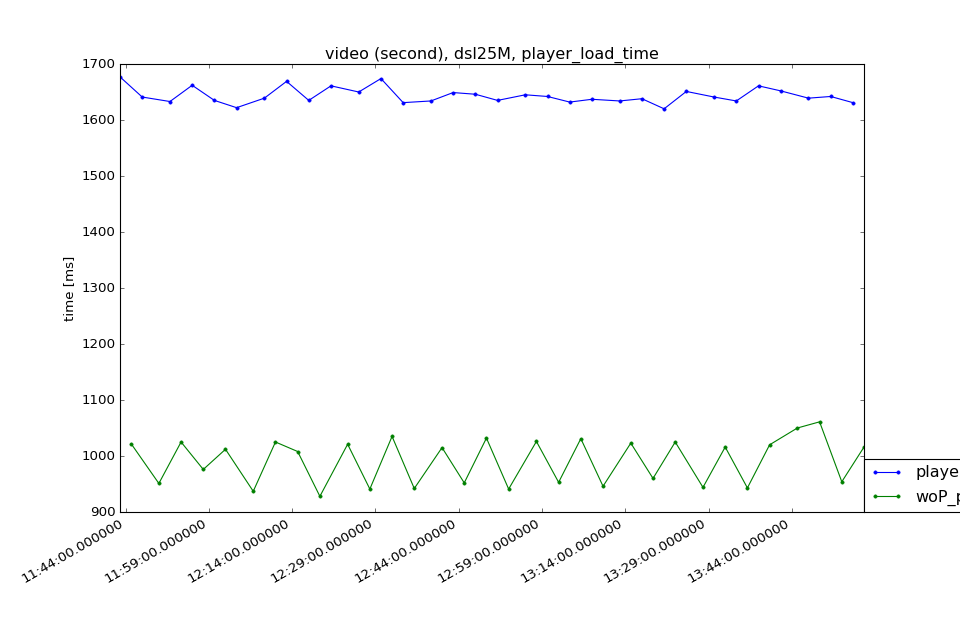

<IPython.core.display.Javascript object>


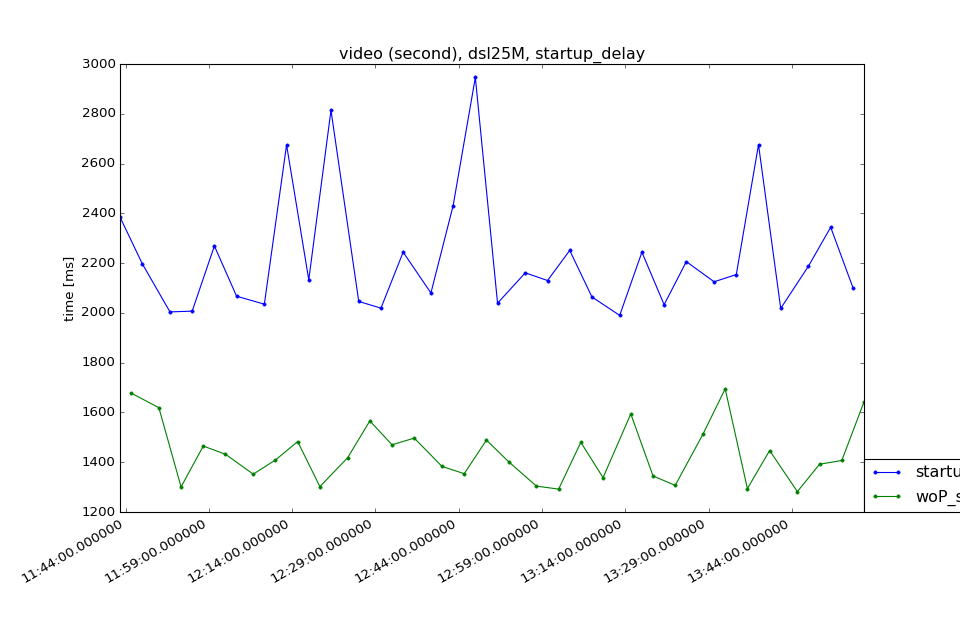

<IPython.core.display.Javascript object>


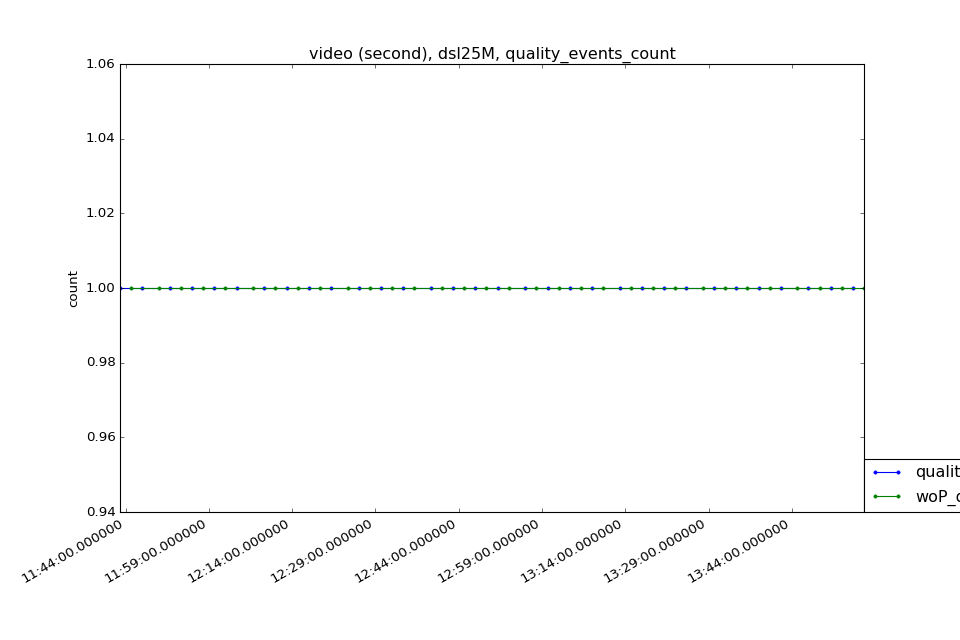

<IPython.core.display.Javascript object>


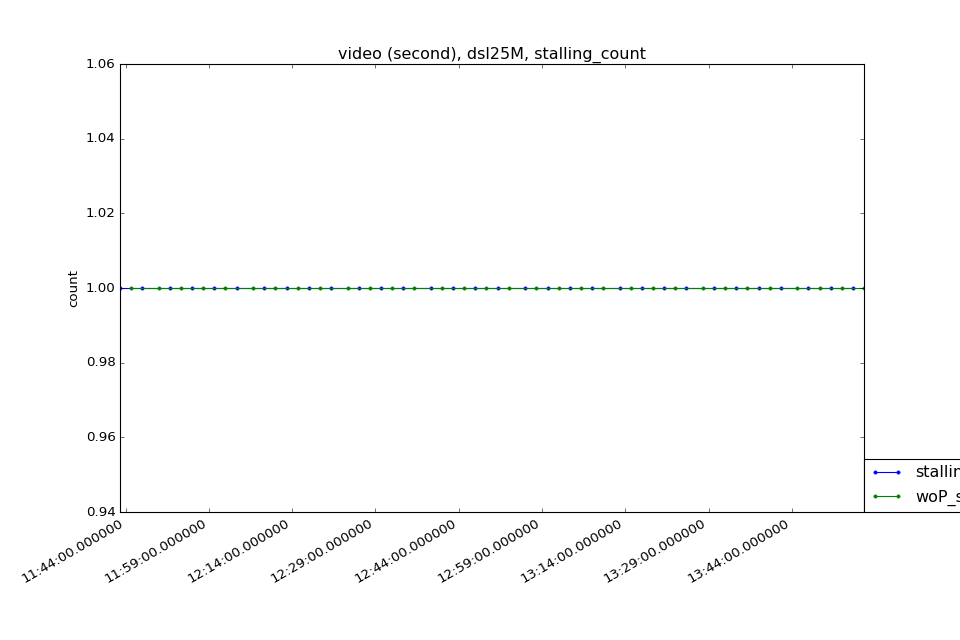

<IPython.core.display.Javascript object>


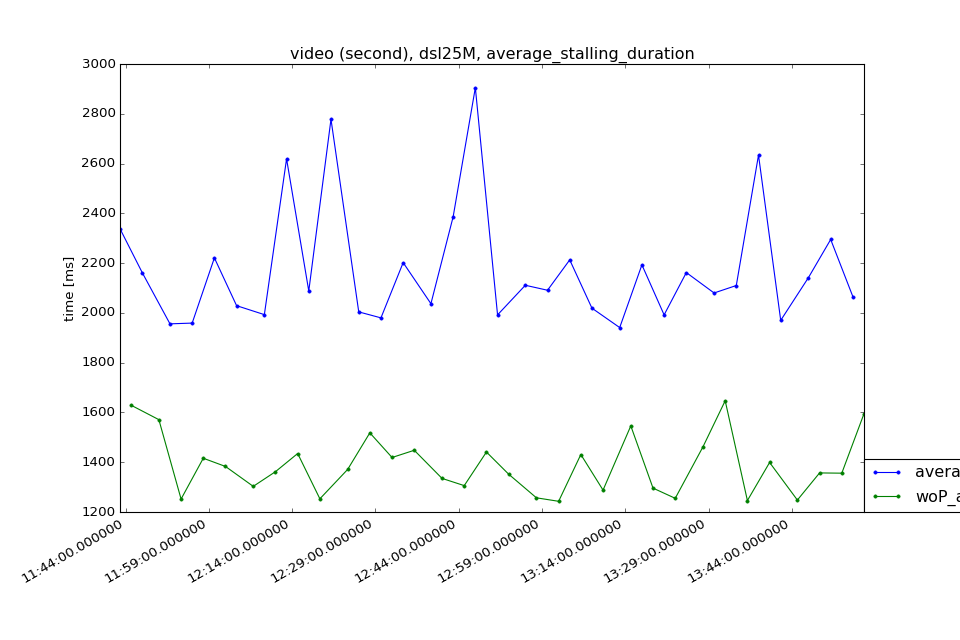

<IPython.core.display.Javascript object>


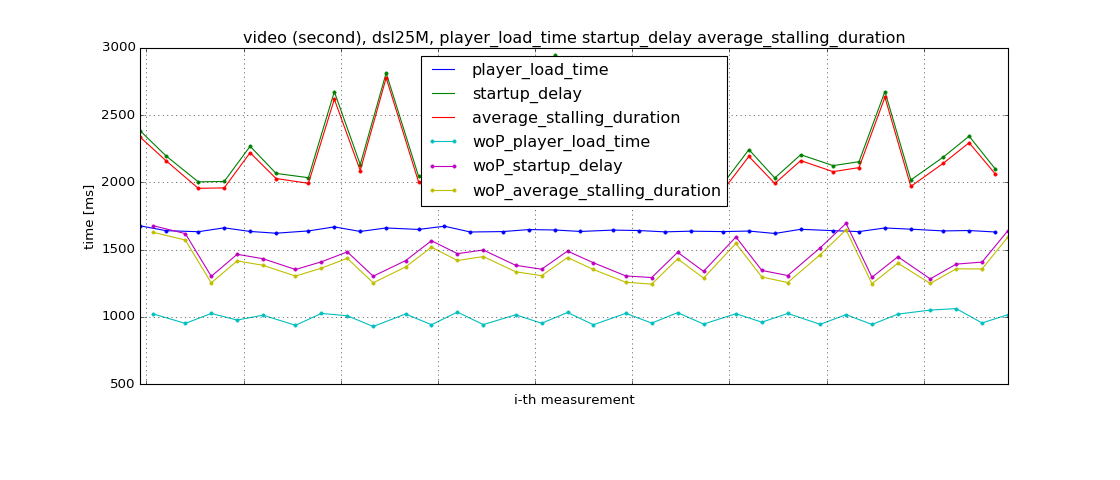

{'hd1080': 32}


<IPython.core.display.Javascript object>


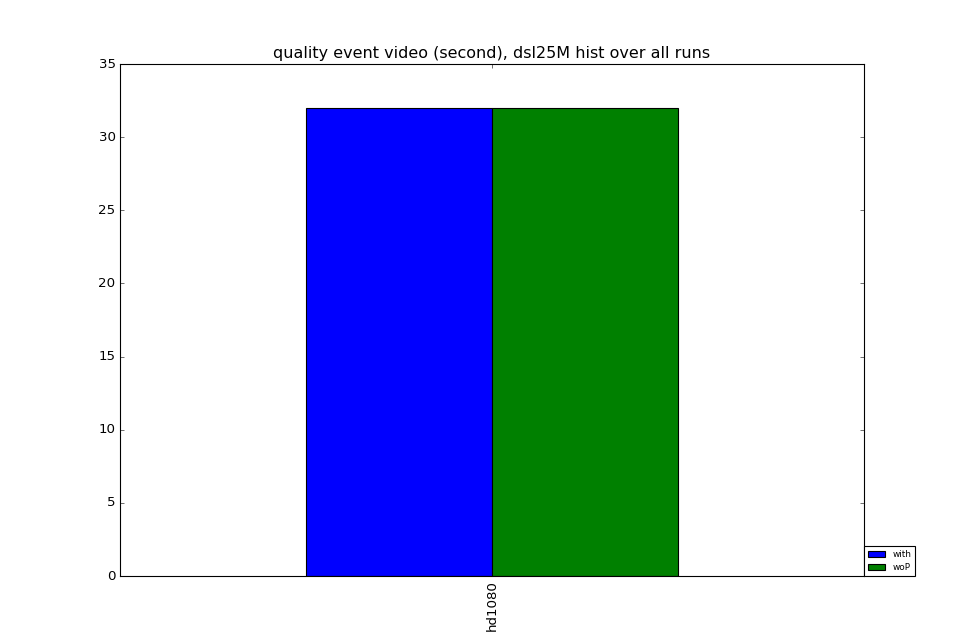

calulate mean
with proxy:
average_stalling_duration    2177.09375
player_load_time             1643.50000
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                2221.18750
dtype: float64
without proxy:
average_stalling_duration    1388.12500
player_load_time              991.59375
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                1436.00000
dtype: float64
mean diff (without - with)
average_stalling_duration   -788.96875
player_load_time            -651.90625
quality_events_count           0.00000
stalling_count                 0.00000
startup_delay               -785.18750
dtype: float64
var diff(without -with)
average_stalling_duration   -46136.23
player_load_time              1498.44
quality_events_count             0.00
stalling_count                   0.00
startup_delay               -45930.16
dtype: float64


In [9]:
basedir = "second_25k"
title = "video (second), dsl25M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)

read with and without proxy files of third_25k


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


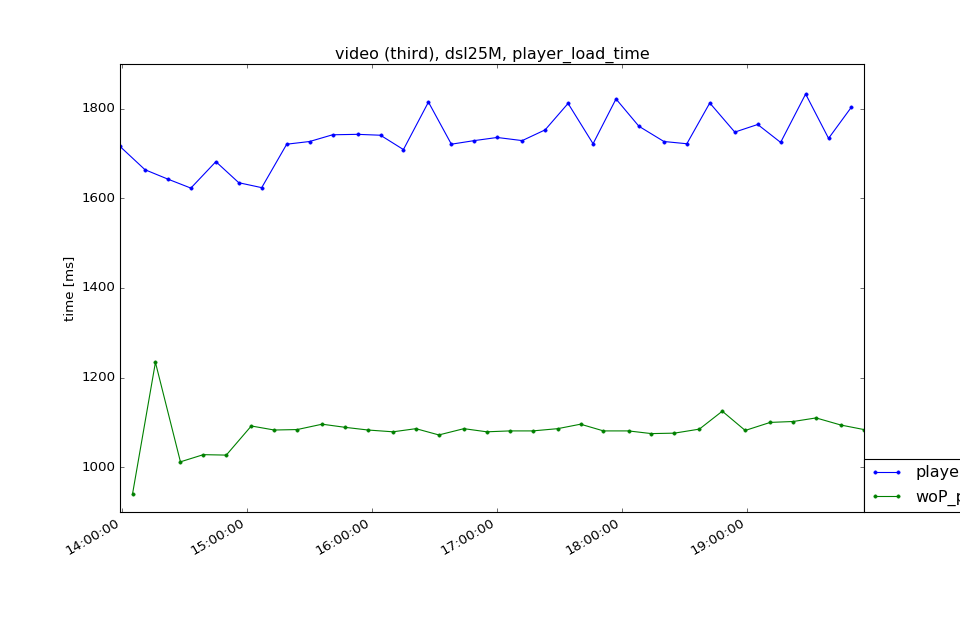

<IPython.core.display.Javascript object>


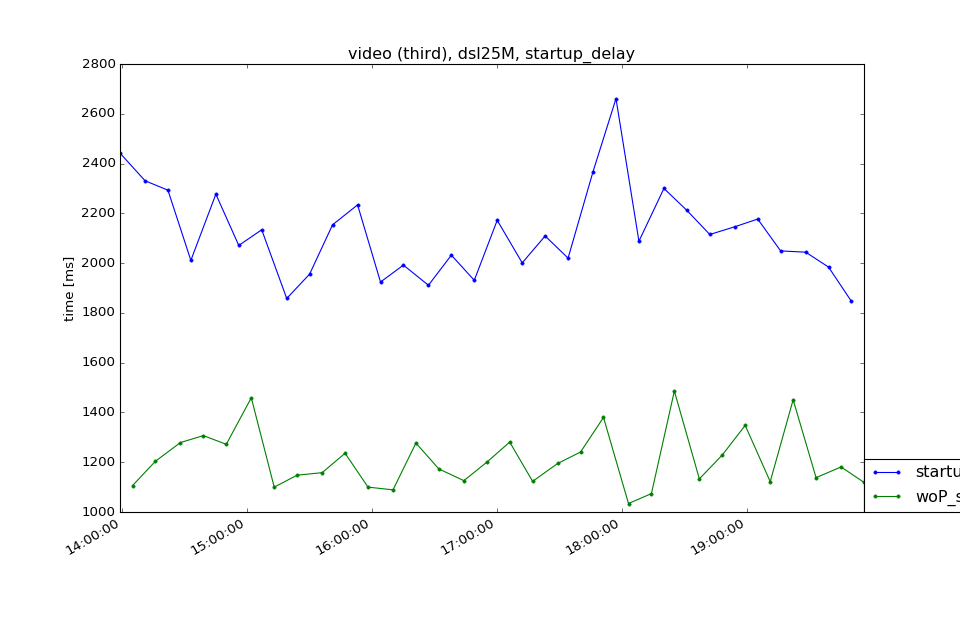

<IPython.core.display.Javascript object>


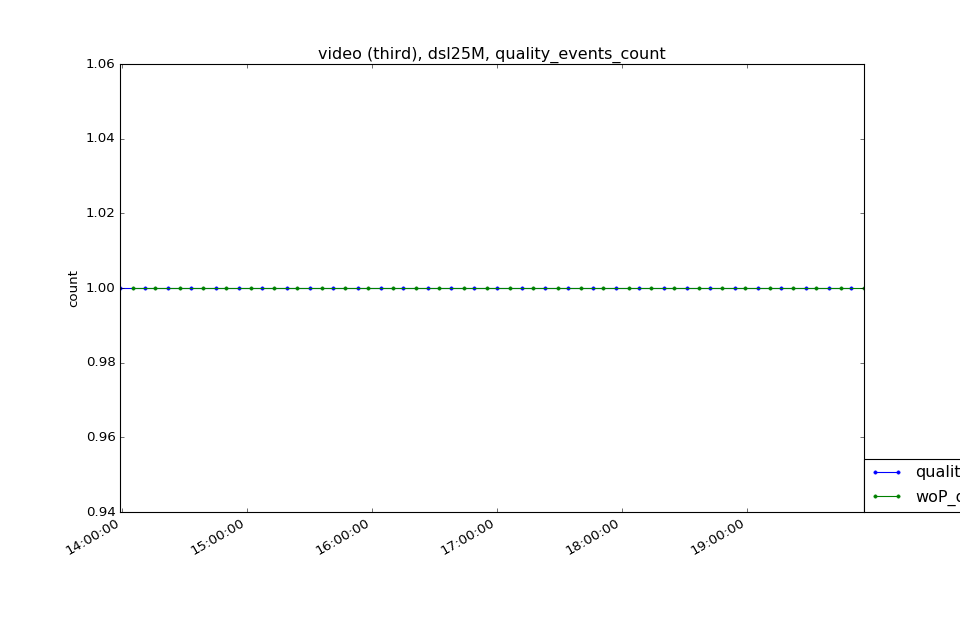

<IPython.core.display.Javascript object>


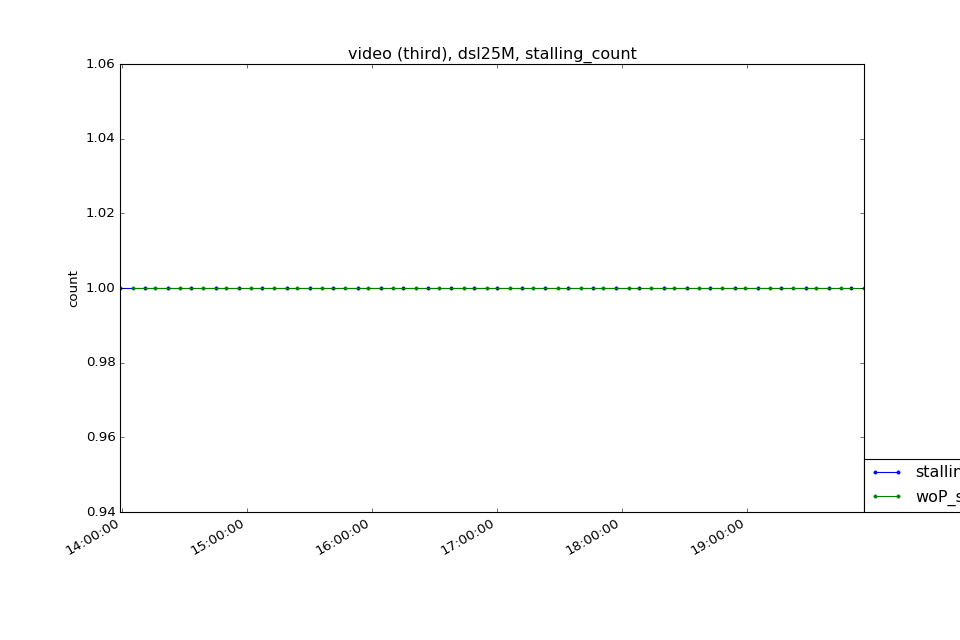

<IPython.core.display.Javascript object>


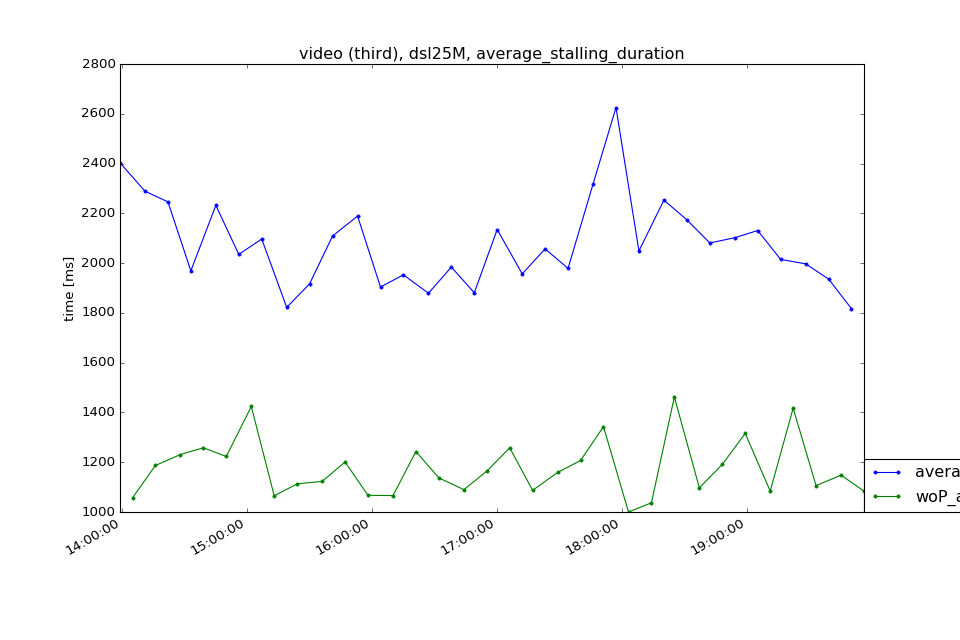

<IPython.core.display.Javascript object>


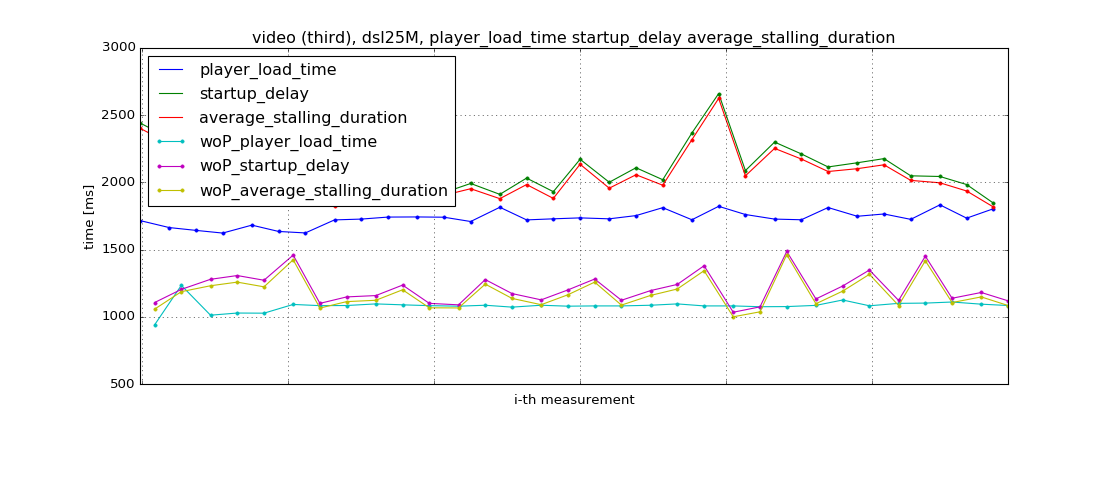

{'hd720': 32}


<IPython.core.display.Javascript object>


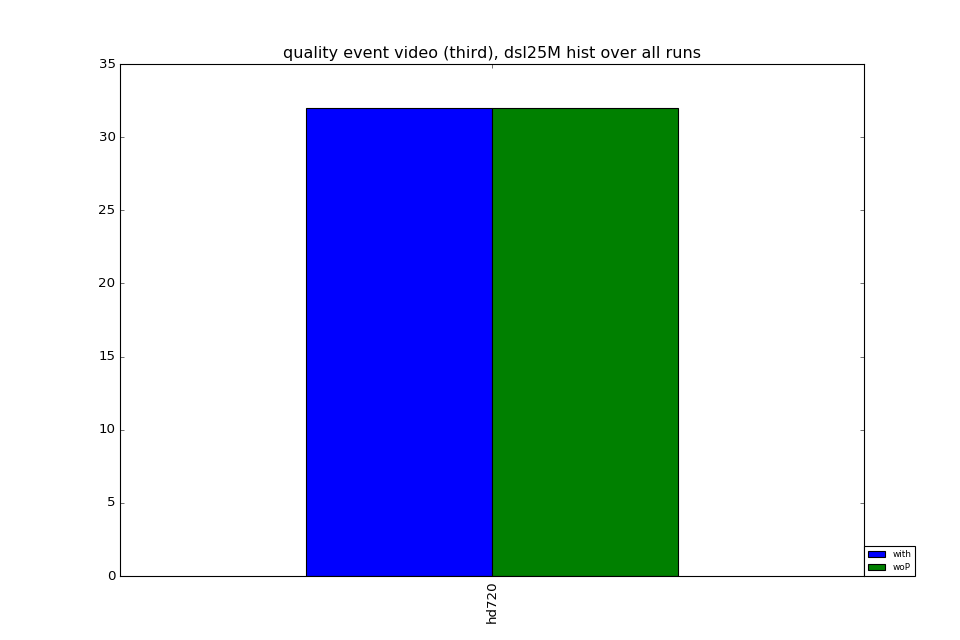

calulate mean
with proxy:
average_stalling_duration    2079.21875
player_load_time             1732.53125
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                2120.09375
dtype: float64
without proxy:
average_stalling_duration    1176.40625
player_load_time             1081.53125
quality_events_count            1.00000
stalling_count                  1.00000
startup_delay                1211.53125
dtype: float64
mean diff (without - with)
average_stalling_duration   -902.8125
player_load_time            -651.0000
quality_events_count           0.0000
stalling_count                 0.0000
startup_delay               -908.5625
dtype: float64
var diff(without -with)
average_stalling_duration   -17877.99
player_load_time             -1200.00
quality_events_count             0.00
stalling_count                   0.00
startup_delay               -18600.54
dtype: float64


In [10]:
basedir = "third_25k"
title = "video (third), dsl25M"
data, data_without_proxy, quali_dist, quali_dist_without_proxy = read_data(basedir)    
print("read with and without proxy files of {}".format(basedir))
print_diagrams_and_results(data, data_without_proxy, title)
print_quali_dist_histo(quali_dist, quali_dist_without_proxy,  title)
print_differences_and_mean(data, data_without_proxy)